<a href="https://colab.research.google.com/github/sushirito/Molecular-Dynamics/blob/main/diffusion_per_region.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.integrate import trapz
import seaborn as sns
import pandas as pd
import pickle

# --- Temperature Diffusion Model Functions ---
k_B = 1.380649e-23  # Boltzmann constant (J/K)
r = (0.102 + 0.168) * 1e-9  # Effective radius (m)
P_C = 22.064e6  # Critical pressure (Pa)
omega = 0.344   # Acentric factor

def dynamic_viscosity(T_K):
    """Compute viscosity at saturated liquid conditions."""
    return 2.414e-5 * 10**(247.8 / (T_K - 140))

def reduced_pressure(P, T_K):
    """Compute reduced pressure using Antoine equation."""
    P_VP = 10**(5.053988 - (1647.6 / (T_K + 226))) * 101325
    return (P - P_VP) / P_C

def lucas_coefficients(T_R):
    """Compute Lucas method coefficients."""
    A = 0.9991 - (4.674e-4 / (1.0523 * T_R - 0.3877 - 1.0513))
    D_val = 0.3257 / (1.0039 - T_R**2.573)**0.2096 - 0.2086
    C_val = (-0.07921 + 2.1616 * T_R - 13.4040 * T_R**2 +
             44.1706 * T_R**3 - 84.8291 * T_R**4 +
             96.1209 * T_R**5 - 59.8127 * T_R**6 + 15.6719 * T_R**7)
    return A, D_val, C_val

def adjusted_viscosity(mu_SL, delta_P_R, A, D_val, C_val):
    """Adjust viscosity using the Lucas method."""
    return mu_SL * (1 + D_val * delta_P_R * A / 2.118) / (1 + C_val * omega * delta_P_R)

def diffusion_coefficient(T_K, r, viscosity):
    """Compute diffusion coefficient using the Einstein-Stokes equation."""
    return k_B * T_K / (6 * np.pi * viscosity * r)


locations = ["Ross Sea", "Lake Superior", "Kodaikanal", "Amazon River", "Guadalupe"]
temperatures_C = [-27.90, 1.67, 17.30, 27.78, 21.60]
pressures_Pa = [98780.0, 101325.0, 101660.0, 101325.0, 102608.0]

region_info = {
    "Ross Sea": {"index": 0, "offsets": {"moderate": 3, "extreme": 6}},
    "Lake Superior": {"index": 1, "offsets": {"moderate": 2, "extreme": 4}},
    "Kodaikanal": {"index": 2, "offsets": {"moderate": 2, "extreme": 4}},
    "Amazon River": {"index": 3, "offsets": {"moderate": 3, "extreme": 6}},
    "Guadalupe": {"index": 4, "offsets": {"moderate": 2, "extreme": 4}},
}

#AC params
activated_carbons = {
    "AC_Type_A": {"q_max": 0.6, "K_L": 0.15, "rho_b": 450, "theta": 0.45},
    "AC_Type_B": {"q_max": 0.7, "K_L": 0.12, "rho_b": 500, "theta": 0.5},
}

v = 0.01          # Flow rate (m/s)
L = 0.5           # Domain length (m)
T_final = 36000   # Final simulation time (s)
T_scaled_max = 1.0
C0 = 100          # Inlet concentration
k_f = 2e-4        # Forward rate constant

def training_phase(retrain=False, save_data=True, data_filename="pinn_data.pkl"):
    """
    Runs PINN training for each region, climate scenario, and activated carbon type.
    """
    if not retrain:
        try:
            with open(data_filename, 'rb') as f:
                loaded_data = pickle.load(f)
                print(f"--- Loaded data from {data_filename} ---")
                return loaded_data['breakthrough_data'], loaded_data['spatial_data']
        except Exception as e:
            print(f"--- Error loading data: {e}. Proceeding with training. ---")

    breakthrough_data = {}
    spatial_data = {}
    scenarios = ["Baseline", "Moderate", "Extreme"]

    for region_name, info in region_info.items():
        idx = info["index"]
        base_temp_C = temperatures_C[idx]
        base_temp_K = base_temp_C + 273.15
        pressure = pressures_Pa[idx]

        for scenario in scenarios:
            temp_offset = 0 if scenario == "Baseline" else info["offsets"][scenario.lower()]
            temp_K = base_temp_K + temp_offset

            # Compute diffusivity using the current temperature diffusion model
            T_R = temp_K / 647.3
            mu_SL = dynamic_viscosity(temp_K)
            A_val, D_val, C_val = lucas_coefficients(T_R)
            delta_P_R = reduced_pressure(pressure, temp_K)
            mu_adjusted = adjusted_viscosity(mu_SL, delta_P_R, A_val, D_val, C_val)
            diffusivity = diffusion_coefficient(temp_K, r, mu_adjusted)

            for carbon_type, params in activated_carbons.items():
                q_max_val = params["q_max"]
                K_L_val = params["K_L"]
                rho_b_val = params["rho_b"]
                theta_val = params["theta"]
                k_r_val = k_f / K_L_val

                key = f"{region_name}_{scenario}_{carbon_type}"
                print(f"\n--- Training for {key} (Temp = {temp_K:.2f} K, D = {diffusivity:.2e} m²/s) ---")

                # Define geometry & time domain
                geom = dde.geometry.Interval(0, L)
                timedomain = dde.geometry.TimeDomain(0, T_scaled_max)
                geomtime = dde.geometry.GeometryXTime(geom, timedomain)

                # Define PDE
                def pde(x, y):
                    C = y[:, 0:1]
                    q = y[:, 1:2]
                    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
                    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
                    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
                    dq_dt = dde.grad.jacobian(q, x, i=0, j=1)
                    adsorption_rate = k_f * C * (q_max_val - q) - k_r_val * q
                    pde_C = dC_dt - (diffusivity/theta_val)*d2C_dx2 + (v/theta_val)*dC_dx + (rho_b_val/theta_val)*dq_dt
                    pde_q = dq_dt - adsorption_rate
                    return [pde_C, pde_q]

                def boundary_inlet(x, on_boundary):
                    return on_boundary and np.isclose(x[0], 0)
                def boundary_outlet(x, on_boundary):
                    return on_boundary and np.isclose(x[0], L)

                ic_C = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=0)
                ic_q = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=1)
                bc_inlet_C = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet, component=0)
                bc_outlet_C = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet, component=0)

                data = dde.data.TimePDE(
                    geomtime,
                    pde,
                    [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
                    num_domain=2000,
                    num_boundary=200,
                    num_initial=100,
                    num_test=500
                )

                net = dde.nn.FNN([2] + [50]*4 + [2], "tanh", "Glorot normal")
                model = dde.Model(data, net)

                model.compile("adam", lr=1e-3)
                model.train(iterations=5000, display_every=1000)
                model.compile("L-BFGS")
                model.train()

                # Prediction grid
                x = np.linspace(0, L, 100)
                t_scaled = np.linspace(0, T_scaled_max, 100)
                t = t_scaled * T_final
                X, T_scaled_grid = np.meshgrid(x, t_scaled)
                grid = np.vstack((X.flatten(), T_scaled_grid.flatten())).T
                y_pred = model.predict(grid)
                C_pred = y_pred[:, 0:1].reshape(X.shape)
                q_pred = y_pred[:, 1:2].reshape(X.shape)

                outlet_idx = np.argmin(np.abs(x - L))
                breakthrough_curve = C_pred[:, outlet_idx]
                C_normalized = breakthrough_curve / C0
                t_array = t / 3600  # Convert time to hours

                breakthrough_data[key] = {
                    'C_normalized': C_normalized,
                    't_array': t_array,
                    'diffusivity': diffusivity,
                    'temp_K': temp_K
                }
                spatial_data[key] = {
                    'C_spatial': C_pred,
                    'q_spatial': q_pred,
                    'x': x,
                    't': t
                }

    if save_data:
        data_to_save = {'breakthrough_data': breakthrough_data, 'spatial_data': spatial_data}
        with open(data_filename, 'wb') as f:
            pickle.dump(data_to_save, f)
        print(f"--- Data saved to {data_filename} ---")

    return breakthrough_data, spatial_data

breakthrough_data_results, spatial_data_results = training_phase(retrain=True)


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.




--- Training for Ross Sea_Baseline_AC_Type_A (Temp = 245.25 K, D = 1.23e-10 m²/s) ---
Compiling model...
Building feed-forward neural network...
'build' took 0.074965 s

'compile' took 1.178370 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [8.14e+03, 8.14e-03, 9.99e+03, 5.74e-03, 3.93e-04, 3.14e-03]    [7.85e+03, 7.85e-03, 9.99e+03, 5.72e-03, 3.95e-04, 3.15e-03]    []  
1000      [1.99e+01, 4.81e-03, 2.41e+03, 4.93e+01, 6.00e+02, 3.18e-05]    [1.62e+01, 3.50e-03, 2.41e+03, 4.93e+01, 6.00e+02, 3.17e-05]    []  
2000      [3.64e+00, 4.76e-02, 6.99e+02, 2.83e+01, 8.46e+01, 1.14e-05]    [2.30e+00, 2.98e-02, 6.99e+02, 2.83e+01, 8.46e+01, 1.15e-05]    []  
3000      [2.85e+00, 4.48e-02, 6.42e+02, 1.36e+01, 1.12e+02, 3.55e-05]    [2.86e+00, 2.98e-02, 6.42e+02, 1.35e+01, 1.12e+02, 3.45e-05]    []  
4000      [1.37e+00, 5.06e-02, 5.93e+02, 2.33e+01, 8.98e+01, 

Summary Table:
           Region  Scenario Carbon  Temp (K)  Diffusivity (m²/s)  \
0        Ross Sea  Baseline     AC    245.25        1.226027e-10   
1        Ross Sea  Baseline     AC    245.25        1.226027e-10   
2        Ross Sea  Moderate     AC    248.25        1.442704e-10   
3        Ross Sea  Moderate     AC    248.25        1.442704e-10   
4        Ross Sea   Extreme     AC    251.25        1.683752e-10   
5        Ross Sea   Extreme     AC    251.25        1.683752e-10   
6   Lake Superior  Baseline     AC    274.82        4.529865e-10   
7   Lake Superior  Baseline     AC    274.82        4.529865e-10   
8   Lake Superior  Moderate     AC    276.82        4.855653e-10   
9   Lake Superior  Moderate     AC    276.82        4.855653e-10   
10  Lake Superior   Extreme     AC    278.82        5.195375e-10   
11  Lake Superior   Extreme     AC    278.82        5.195375e-10   
12     Kodaikanal  Baseline     AC    290.45        7.452445e-10   
13     Kodaikanal  Baseline     A

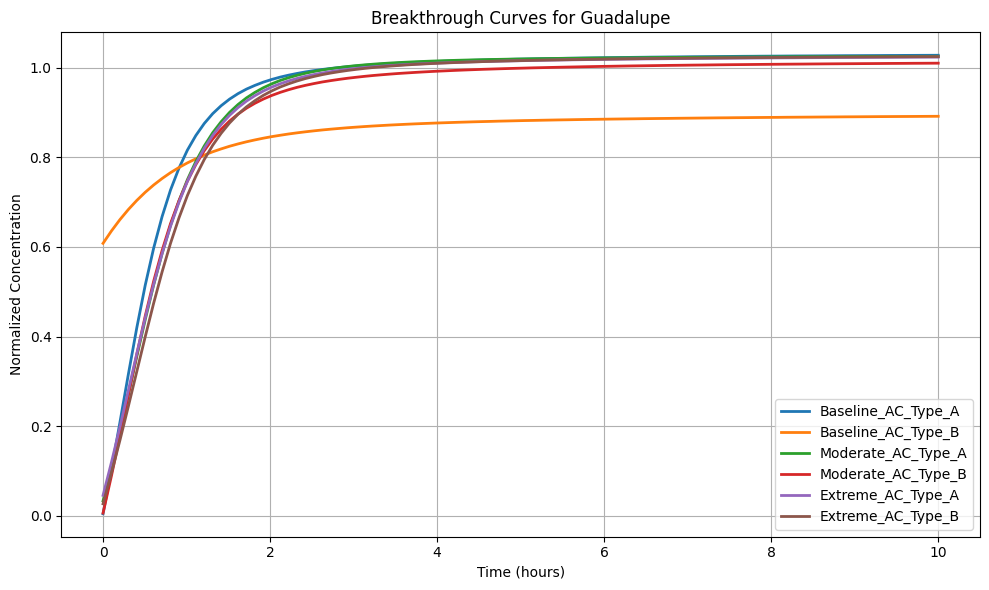

<Figure size 1200x600 with 0 Axes>

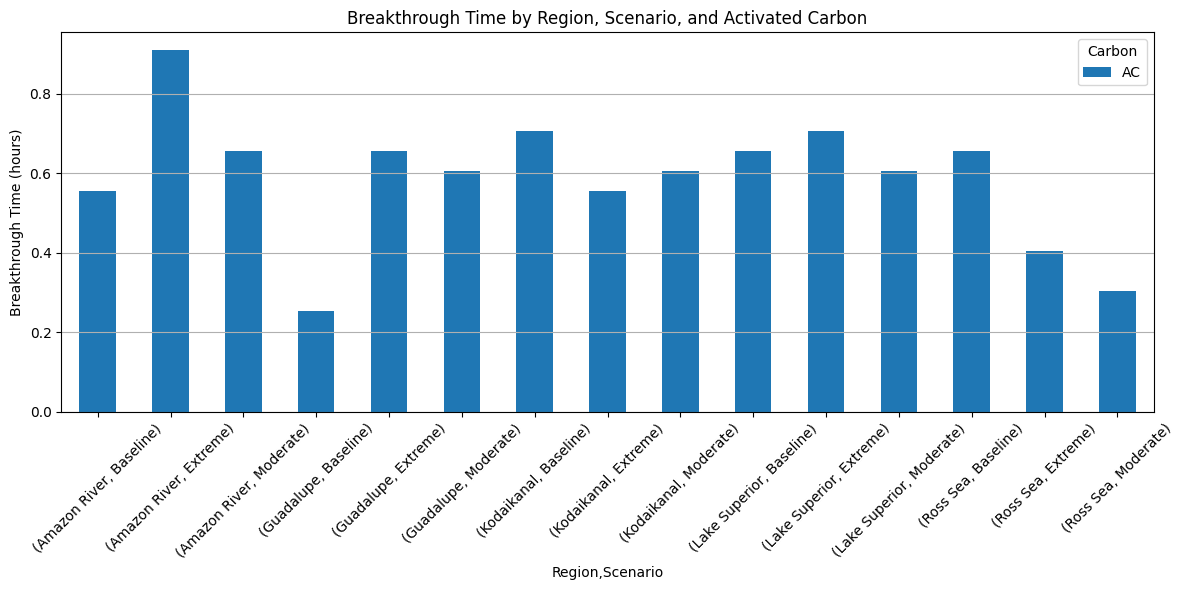

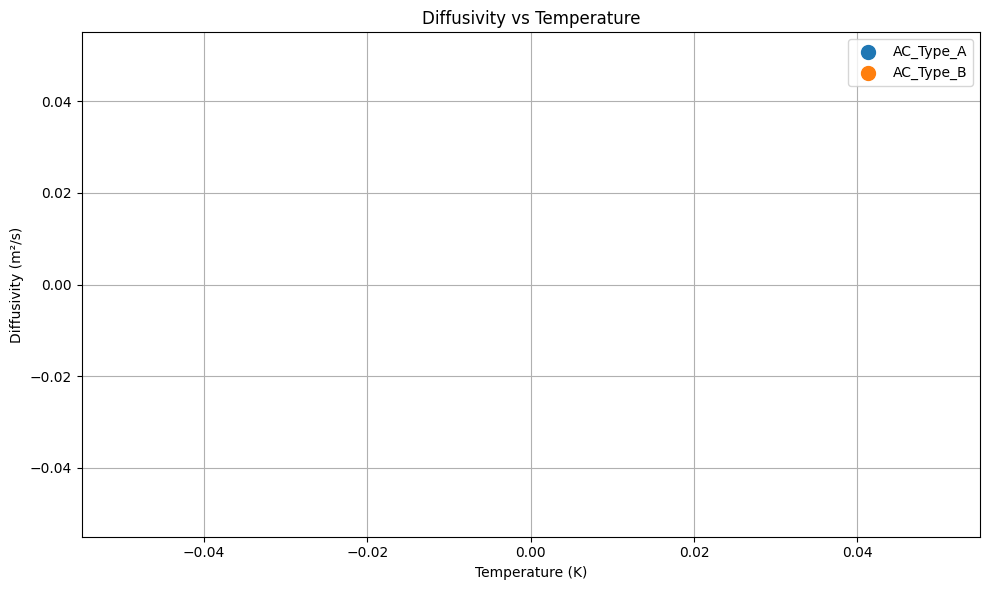

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

records = []
threshold = 0.5

for key, data in breakthrough_data_results.items():
    parts = key.split('_')
    region = parts[0]
    scenario = parts[1]
    carbon = parts[2]
    temp_K = data['temp_K']
    diffusivity = data['diffusivity']
    t_array = data['t_array']
    C_norm = data['C_normalized']

    idx = np.where(C_norm >= threshold)[0]
    breakthrough_time = t_array[idx[0]] if len(idx) > 0 else np.nan

    records.append({
        "Region": region,
        "Scenario": scenario,
        "Carbon": carbon,
        "Temp (K)": temp_K,
        "Diffusivity (m²/s)": diffusivity,
        "Breakthrough Time (h)": breakthrough_time
    })

df_summary = pd.DataFrame(records)
print("Summary Table:")
print(df_summary)
df_summary.to_csv("breakthrough_summary.csv", index=False)

region_to_plot = "Guadalupe"
plt.figure(figsize=(10, 6))
for key, data in breakthrough_data_results.items():
    if key.startswith(region_to_plot):
        t_array = data['t_array']
        C_norm = data['C_normalized']
        label = "_".join(key.split('_')[1:])
        plt.plot(t_array, C_norm, label=label, linewidth=2)
plt.xlabel("Time (hours)")
plt.ylabel("Normalized Concentration")
plt.title(f"Breakthrough Curves for {region_to_plot}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
df_pivot = df_summary.pivot_table(index=["Region", "Scenario"], columns="Carbon", values="Breakthrough Time (h)")
df_pivot.plot(kind="bar", figsize=(12, 6))
plt.ylabel("Breakthrough Time (hours)")
plt.title("Breakthrough Time by Region, Scenario, and Activated Carbon")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
for carbon in activated_carbons.keys():
    sub_df = df_summary[df_summary["Carbon"] == carbon]
    plt.scatter(sub_df["Temp (K)"], sub_df["Diffusivity (m²/s)"], s=100, label=carbon)
plt.xlabel("Temperature (K)")
plt.ylabel("Diffusivity (m²/s)")
plt.title("Diffusivity vs Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

# --- Visualization Phase Code Block ---
def visualization_phase(breakthrough_data, spatial_data):
    """
    Generates all the plots based on the provided data.

    Args:
        breakthrough_data (dict): Dictionary containing breakthrough curve data per region.
        spatial_data (dict): Dictionary containing spatial concentration data per region.
    """
    region_names = list(region_diffusivities.keys())
    colors = plt.cm.viridis(np.linspace(0, 1, len(region_names)))


    plt.figure(figsize=(10, 6))
    for i, region_name in enumerate(region_names):
        data = breakthrough_data[region_name]
        plt.plot(data['t_array'], data['C_normalized'], label=region_name, color=colors[i])

    plt.xlabel('Time (hours)')
    plt.ylabel('C/C₀')
    plt.title('Breakthrough Curves for Different Regions')
    plt.axhline(0.05, color='r', linestyle='--', label='Breakthrough (5%)')
    plt.axhline(0.95, color='g', linestyle='--', label='Exhaustion (95%)')
    plt.legend(title='Regions')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    spatial_profiles_figures = {}
    for region_name in region_names:
        spatial_fig = plt.figure()
        spatial_profiles_figures[region_name] = spatial_fig
        ax_spatial = spatial_fig.add_subplot(1, 1, 1)
        C_pred = spatial_data[region_name]['C_spatial']
        x = spatial_data[region_name]['x']
        t = spatial_data[region_name]['t']
        num_time_points = C_pred.shape[0]
        time_indices = [0, num_time_points // 4, num_time_points // 2, 3 * num_time_points // 4, num_time_points - 1]
        time_labels_spatial = [f'{t[ti] / 3600:.1f} hours' for ti in time_indices]
        for idx, ti in enumerate(time_indices):
            ax_spatial.plot(x, C_pred[ti, :], label=f'Time: {time_labels_spatial[idx]}')
        ax_spatial.set_xlabel('Column Length (m)')
        ax_spatial.set_ylabel('Concentration (mg/L)')
        ax_spatial.set_title(f'Spatial Concentration Profiles - {region_name}')
        ax_spatial.legend(title='Time Points')
        ax_spatial.grid(True)
        spatial_fig.tight_layout()
        spatial_fig.show()


    plt.figure(figsize=(12, 6))

    breakthrough_times = {}
    exhaustion_times = {}
    auc_values = {}

    for region_name, data in breakthrough_data.items():
        C_normalized = data['C_normalized']
        t_array = data['t_array']

        #Find Breakthrough Time (5%)
        breakthrough_index = np.where(C_normalized >= 0.05)[0]
        if len(breakthrough_index) > 0:
            breakthrough_times[region_name] = t_array[breakthrough_index[0]]
        else:
            breakthrough_times[region_name] = np.nan

        #Find Exhaustion Time (95%)
        exhaustion_index = np.where(C_normalized >= 0.95)[0]
        if len(exhaustion_index) > 0:
            exhaustion_times[region_name] = t_array[exhaustion_index[0]]
        else:
            exhaustion_times[region_name] = np.nan

        # Calculate AUC
        valid_indices_auc = np.where(~np.isnan(C_normalized))[0] # Avoid NaN in integration
        if not np.isnan(exhaustion_times[region_name]):
            exhaustion_time_auc = exhaustion_times[region_name]
            exhaustion_index_auc = np.where(t_array <= exhaustion_time_auc)[0][-1] if len(np.where(t_array <= exhaustion_time_auc)[0]) > 0 else -1
            if exhaustion_index_auc > 0:
                auc_values[region_name] = trapz(C_normalized[:exhaustion_index_auc+1], t_array[:exhaustion_index_auc+1])
            else:
                 auc_values[region_name] = 0
        else: #If no exhaustion, calculate AUC over full simulation time.
            auc_values[region_name] = trapz(C_normalized[valid_indices_auc], t_array[valid_indices_auc]) if len(valid_indices_auc) > 1 else 0


    bar_width = 0.35
    r1 = np.arange(len(region_names))
    r2 = [x + bar_width for x in r1]

    plt.subplot(1, 2, 1)
    plt.bar(r1, [breakthrough_times.get(region, 0) for region in region_names], color='skyblue', width=bar_width, edgecolor='grey', label='Breakthrough Time (5%)')
    plt.bar(r2, [exhaustion_times.get(region, 0) for region in region_names], color='salmon', width=bar_width, edgecolor='grey', label='Exhaustion Time (95%)')
    plt.xlabel('Region', fontweight='bold')
    plt.xticks([r + bar_width / 2 for r in r1], region_names, rotation=45, ha='right')
    plt.ylabel('Time (hours)', fontweight='bold')
    plt.title('Breakthrough & Exhaustion Times Comparison', fontweight='bold')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.bar(region_names, [auc_values.get(region, 0) for region in region_names], color='lightgreen', edgecolor='grey', label='AUC')
    plt.xlabel('Region', fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('AUC (Normalized Concentration * hours)', fontweight='bold')
    plt.title('Area Under Breakthrough Curve (AUC)', fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.show()


    plot_concentration_heatmap(spatial_data, region_names, selected_regions=["Guadalupe", "Ross Sea", "Amazon River"])
    plot_adsorbed_phase_heatmap(spatial_data, region_names, selected_regions=["Guadalupe", "Ross Sea", "Amazon River"])
    plot_adsorption_front_velocity(breakthrough_data, region_names, front_level=0.05)


def plot_concentration_heatmap(spatial_data, region_names, selected_regions=None):
    if selected_regions is None:
        regions_to_plot = region_names
    else:
        regions_to_plot = selected_regions

    for region_name in regions_to_plot:
        data = spatial_data[region_name]
        C_spatial = data['C_spatial']
        x = data['x']
        t = data['t']
        df_C = pd.DataFrame(data=C_spatial, index=t/3600, columns=x)

        plt.figure(figsize=(8, 6))
        sns.heatmap(df_C, cmap="viridis", cbar_kws={'label': 'Concentration (mg/L)'}, xticklabels=5, yticklabels=5) # Changed cbar_label to cbar_kws
        plt.xlabel('Column Length (m)')
        plt.ylabel('Time (hours)')
        plt.title(f'Spatial Concentration Heatmap - {region_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

def plot_adsorbed_phase_heatmap(spatial_data, region_names, selected_regions=None):
    if selected_regions is None:
        regions_to_plot = region_names
    else:
        regions_to_plot = selected_regions

    for region_name in regions_to_plot:
        data = spatial_data[region_name]
        q_spatial = data['q_spatial']
        x = data['x']
        t = data['t']
        df_q = pd.DataFrame(data=q_spatial, index=t/3600, columns=x)

        plt.figure(figsize=(8, 6))
        sns.heatmap(df_q, cmap="magma", cbar_kws={'label': 'Adsorbed Concentration (mg/g)'}, xticklabels=5, yticklabels=5)
        plt.xlabel('Column Length (m)')
        plt.ylabel('Time (hours)')
        plt.title(f'Spatial Adsorbed Phase Heatmap - {region_name}')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

def plot_adsorption_front_velocity(breakthrough_data, region_names, front_level=0.05):
    plt.figure(figsize=(8, 6))
    for region_name in region_names:
        data = breakthrough_data[region_name]
        C_normalized = data['C_normalized']
        t_array = data['t_array']
        x = spatial_data[region_name]['x']

        front_positions = []
        for j_time in range(len(t_array)):
            C_profile_at_t = spatial_data[region_name]['C_spatial'][j_time,:]/C0
            breakthrough_pos_indices = np.where(C_profile_at_t >= front_level)[0]
            if len(breakthrough_pos_indices) > 0:
                front_position = x[breakthrough_pos_indices[0]]
            else:
                front_position = 0

            front_positions.append(front_position)

        plt.plot(t_array, front_positions, label=region_name, linewidth=2)

    plt.xlabel('Time (hours)')
    plt.ylabel('Adsorption Front Position (m)')
    plt.title(f'Adsorption Front Velocity Comparison (C/C₀ = {front_level*100:.0f}%)')
    plt.legend(title='Regions')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


if breakthrough_data_results and spatial_data_results: # Only visualize if data loading/training was successful
    visualization_phase(breakthrough_data_results, spatial_data_results)
    print("\n--- Visualization Phase Completed ---")
else:
    print("\n--- No data available for visualization. Run training_phase with retrain=True first. ---")

NameError: name 'region_diffusivities' is not defined

#New Code Mar 6

In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.integrate import trapz
import pandas as pd
import pickle

# --- Temperature Diffusion Model Functions ---
k_B = 1.380649e-23  # Boltzmann constant (J/K)
r = (0.102 + 0.168) * 1e-9  # Effective radius (m)
P_C = 22.064e6  # Critical pressure (Pa)
omega = 0.344   # Acentric factor

def dynamic_viscosity(T_K):
    return 2.414e-5 * 10**(247.8 / (T_K - 140))

def reduced_pressure(P, T_K):
    P_VP = 10**(5.053988 - (1647.6 / (T_K + 226))) * 101325
    return (P - P_VP) / P_C

def lucas_coefficients(T_R):
    A = 0.9991 - (4.674e-4 / (1.0523 * T_R - 0.3877 - 1.0513))
    D_val = 0.3257 / (1.0039 - T_R**2.573)**0.2096 - 0.2086
    C_val = (-0.07921 + 2.1616 * T_R - 13.4040 * T_R**2 +
             44.1706 * T_R**3 - 84.8291 * T_R**4 +
             96.1209 * T_R**5 - 59.8127 * T_R**6 + 15.6719 * T_R**7)
    return A, D_val, C_val

def adjusted_viscosity(mu_SL, delta_P_R, A, D_val, C_val):
    return mu_SL * (1 + D_val * delta_P_R * A / 2.118) / (1 + C_val * omega * delta_P_R)

def diffusion_coefficient(T_K, r, viscosity):
    return k_B * T_K / (6 * np.pi * viscosity * r)

# --- Environmental Conditions ---
locations = ["Ross Sea", "Lake Superior", "Kodaikanal", "Amazon River", "Guadalupe"]
temperatures_C = [-27.90, 1.67, 17.30, 27.78, 21.60]
pressures_Pa = [98780.0, 101325.0, 101660.0, 101325.0, 102608.0]

region_info = {
    "Ross Sea": {"index": 0, "offsets": {"moderate": 3, "extreme": 6}},
    "Lake Superior": {"index": 1, "offsets": {"moderate": 2, "extreme": 4}},
    "Kodaikanal": {"index": 2, "offsets": {"moderate": 2, "extreme": 4}},
    "Amazon River": {"index": 3, "offsets": {"moderate": 3, "extreme": 6}},
    "Guadalupe": {"index": 4, "offsets": {"moderate": 2, "extreme": 4}},
}

# --- Operating Conditions & Base AC Params ---
v = 0.01          # Flow rate (m/s)
L = 0.5           # Domain length (m)
T_final = 36000   # Final simulation time (s)
T_scaled_max = 1.0
C0 = 100          # Inlet concentration
k_f = 2e-4        # Forward rate constant

# Original activated carbon parameters (used in training phase)
activated_carbons = {
    "AC_Type_A": {"q_max": 0.6, "K_L": 0.15, "rho_b": 450, "theta": 0.45},
    "AC_Type_B": {"q_max": 0.7, "K_L": 0.12, "rho_b": 500, "theta": 0.5},
}

def training_phase(retrain=False, save_data=True, data_filename="pinn_data.pkl"):
    """
    Runs PINN training for each region, climate scenario, and activated carbon type.
    """
    if not retrain:
        try:
            with open(data_filename, 'rb') as f:
                loaded_data = pickle.load(f)
                print(f"--- Loaded data from {data_filename} ---")
                return loaded_data['breakthrough_data'], loaded_data['spatial_data']
        except Exception as e:
            print(f"--- Error loading data: {e}. Proceeding with training. ---")

    breakthrough_data = {}
    spatial_data = {}
    scenarios = ["Baseline", "Moderate", "Extreme"]

    for region_name, info in region_info.items():
        idx = info["index"]
        base_temp_C = temperatures_C[idx]
        base_temp_K = base_temp_C + 273.15
        pressure = pressures_Pa[idx]

        for scenario in scenarios:
            temp_offset = 0 if scenario == "Baseline" else info["offsets"][scenario.lower()]
            temp_K = base_temp_K + temp_offset

            T_R = temp_K / 647.3
            mu_SL = dynamic_viscosity(temp_K)
            A_val, D_val, C_val = lucas_coefficients(T_R)
            delta_P_R = reduced_pressure(pressure, temp_K)
            mu_adjusted = adjusted_viscosity(mu_SL, delta_P_R, A_val, D_val, C_val)
            diffusivity = diffusion_coefficient(temp_K, r, mu_adjusted)

            for carbon_type, params in activated_carbons.items():
                q_max_val = params["q_max"]
                K_L_val = params["K_L"]
                rho_b_val = params["rho_b"]
                theta_val = params["theta"]
                k_r_val = k_f / K_L_val

                key = f"{region_name}_{scenario}_{carbon_type}"
                print(f"\n--- Training for {key} (Temp = {temp_K:.2f} K, D = {diffusivity:.2e} m²/s) ---")

                geom = dde.geometry.Interval(0, L)
                timedomain = dde.geometry.TimeDomain(0, T_scaled_max)
                geomtime = dde.geometry.GeometryXTime(geom, timedomain)

                def pde(x, y):
                    C = y[:, 0:1]
                    q = y[:, 1:2]
                    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
                    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
                    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
                    dq_dt = dde.grad.jacobian(q, x, i=0, j=1)
                    adsorption_rate = k_f * C * (q_max_val - q) - k_r_val * q
                    pde_C = dC_dt - (diffusivity/theta_val)*d2C_dx2 + (v/theta_val)*dC_dx + (rho_b_val/theta_val)*dq_dt
                    pde_q = dq_dt - adsorption_rate
                    return [pde_C, pde_q]

                def boundary_inlet(x, on_boundary):
                    return on_boundary and np.isclose(x[0], 0)
                def boundary_outlet(x, on_boundary):
                    return on_boundary and np.isclose(x[0], L)

                ic_C = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=0)
                ic_q = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=1)
                bc_inlet_C = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet, component=0)
                bc_outlet_C = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet, component=0)

                data = dde.data.TimePDE(
                    geomtime,
                    pde,
                    [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
                    num_domain=2000,
                    num_boundary=200,
                    num_initial=100,
                    num_test=500
                )

                net = dde.nn.FNN([2] + [50]*4 + [2], "tanh", "Glorot normal")
                model = dde.Model(data, net)

                model.compile("adam", lr=1e-3)
                model.train(iterations=5000, display_every=1000)
                model.compile("L-BFGS")
                model.train()

                # Prediction grid
                x = np.linspace(0, L, 100)
                t_scaled = np.linspace(0, T_scaled_max, 100)
                t = t_scaled * T_final
                X, T_scaled_grid = np.meshgrid(x, t_scaled)
                grid = np.vstack((X.flatten(), T_scaled_grid.flatten())).T
                y_pred = model.predict(grid)
                C_pred = y_pred[:, 0:1].reshape(X.shape)
                # breakthrough: outlet concentration
                outlet_idx = np.argmin(np.abs(x - L))
                breakthrough_curve = C_pred[:, outlet_idx]
                C_normalized = breakthrough_curve / C0
                t_array = t / 3600  # in hours

                breakthrough_data[key] = {
                    'C_normalized': C_normalized,
                    't_array': t_array,
                    'diffusivity': diffusivity,
                    'temp_K': temp_K
                }
                spatial_data[key] = {
                    'C_spatial': C_pred,
                    'x': x,
                    't': t
                }
    if save_data:
        with open(data_filename, 'wb') as f:
            pickle.dump({'breakthrough_data': breakthrough_data, 'spatial_data': spatial_data}, f)
        print(f"--- Data saved ---")
    return breakthrough_data, spatial_data

# First, run the standard training phase.
breakthrough_data_results, spatial_data_results = training_phase(retrain=True)

# --- Parameter Study: Varying q_max and K_L ---
# Define uniform sampling ranges
q_max_vals = np.linspace(0.5, 0.8, 3)   # example: 0.5, 0.65, 0.8
K_L_vals = np.linspace(0.1, 0.2, 3)       # example: 0.1, 0.15, 0.2

def compute_breakthrough_time(t_array, C_norm, threshold=0.5):
    """
    Returns the breakthrough time when the normalized concentration exceeds the threshold.
    """
    above_thresh = np.where(C_norm >= threshold)[0]
    if len(above_thresh) > 0:
        return t_array[above_thresh[0]]
    else:
        return np.nan

# Dictionary to store study results
study_results = {}

# Loop over regions, scenarios, and parameter samples.
scenarios = ["Baseline", "Moderate", "Extreme"]
for region_name, info in region_info.items():
    idx = info["index"]
    base_temp_C = temperatures_C[idx]
    base_temp_K = base_temp_C + 273.15
    pressure = pressures_Pa[idx]
    for scenario in scenarios:
        # Determine temperature for scenario
        temp_offset = 0 if scenario == "Baseline" else info["offsets"][scenario.lower()]
        temp_K = base_temp_K + temp_offset
        T_R = temp_K / 647.3
        mu_SL = dynamic_viscosity(temp_K)
        A_val, D_val, C_val = lucas_coefficients(T_R)
        delta_P_R = reduced_pressure(pressure, temp_K)
        mu_adjusted = adjusted_viscosity(mu_SL, delta_P_R, A_val, D_val, C_val)
        diffusivity = diffusion_coefficient(temp_K, r, mu_adjusted)

        # Use a fixed rho_b and theta (typical values) for the study
        rho_b_val = 450
        theta_val = 0.45

        for q_max_val in q_max_vals:
            for K_L_val in K_L_vals:
                k_r_val = k_f / K_L_val
                # Define a unique key for this study
                key = f"{region_name}_{scenario}_qmax{q_max_val:.2f}_KL{K_L_val:.2f}"
                print(f"\n--- Studying {key} (Temp = {temp_K:.2f} K) ---")
                # Setup geometry & time domain
                geom = dde.geometry.Interval(0, L)
                timedomain = dde.geometry.TimeDomain(0, T_scaled_max)
                geomtime = dde.geometry.GeometryXTime(geom, timedomain)

                def pde(x, y):
                    C = y[:, 0:1]
                    q = y[:, 1:2]
                    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
                    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
                    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
                    dq_dt = dde.grad.jacobian(q, x, i=0, j=1)
                    adsorption_rate = k_f * C * (q_max_val - q) - k_r_val * q
                    pde_C = dC_dt - (diffusivity/theta_val)*d2C_dx2 + (v/theta_val)*dC_dx + (rho_b_val/theta_val)*dq_dt
                    pde_q = dq_dt - adsorption_rate
                    return [pde_C, pde_q]

                def boundary_inlet(x, on_boundary):
                    return on_boundary and np.isclose(x[0], 0)
                def boundary_outlet(x, on_boundary):
                    return on_boundary and np.isclose(x[0], L)

                ic_C = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=0)
                ic_q = dde.icbc.IC(geomtime, lambda x: 0, lambda x, _: np.isclose(x[1], 0), component=1)
                bc_inlet_C = dde.icbc.DirichletBC(geomtime, lambda x: C0, boundary_inlet, component=0)
                bc_outlet_C = dde.icbc.NeumannBC(geomtime, lambda x: 0, boundary_outlet, component=0)

                data = dde.data.TimePDE(
                    geomtime,
                    pde,
                    [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
                    num_domain=2000,
                    num_boundary=200,
                    num_initial=100,
                    num_test=500
                )

                net = dde.nn.FNN([2] + [50]*4 + [2], "tanh", "Glorot normal")
                model = dde.Model(data, net)
                model.compile("adam", lr=1e-3)
                model.train(iterations=5000, display_every=1000)
                model.compile("L-BFGS")
                model.train()

                # Prediction grid
                x = np.linspace(0, L, 100)
                t_scaled = np.linspace(0, T_scaled_max, 100)
                t = t_scaled * T_final
                X, T_scaled_grid = np.meshgrid(x, t_scaled)
                grid = np.vstack((X.flatten(), T_scaled_grid.flatten())).T
                y_pred = model.predict(grid)
                C_pred = y_pred[:, 0:1].reshape(X.shape)
                outlet_idx = np.argmin(np.abs(x - L))
                breakthrough_curve = C_pred[:, outlet_idx]
                C_normalized = breakthrough_curve / C0
                t_array = t / 3600  # in hours

                t_brk = compute_breakthrough_time(t_array, C_normalized, threshold=0.5)
                study_results[key] = t_brk
                print(f"Breakthrough time (C/C0=0.5): {t_brk:.2f} hours")

# Optionally, output the study results as a DataFrame
results_df = pd.DataFrame(list(study_results.items()), columns=["Case", "Breakthrough Time (hrs)"])
print("\nParameter Study Results:")
print(results_df)


No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.




--- Training for Ross Sea_Baseline_AC_Type_A (Temp = 245.25 K, D = 1.23e-10 m²/s) ---
Compiling model...
Building feed-forward neural network...
'build' took 0.074207 s

'compile' took 0.974880 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [5.87e+02, 5.83e-04, 1.00e+04, 5.80e-02, 5.94e-03, 2.01e-04]    [6.23e+02, 6.18e-04, 1.00e+04, 5.79e-02, 5.95e-03, 1.99e-04]    []  
1000      [5.72e+02, 6.18e-04, 2.40e+03, 4.95e+00, 9.88e+02, 3.45e-05]    [4.44e+02, 3.85e-04, 2.40e+03, 4.96e+00, 9.88e+02, 3.35e-05]    []  
2000      [5.43e+01, 5.98e-02, 4.82e+02, 1.24e+01, 3.88e+01, 8.32e-06]    [1.59e+01, 3.39e-02, 4.82e+02, 1.23e+01, 3.88e+01, 8.45e-06]    []  
3000      [1.23e+02, 1.00e-01, 2.78e+02, 9.77e+00, 2.23e+01, 1.16e-05]    [3.93e+01, 5.00e-02, 2.78e+02, 9.70e+00, 2.23e+01, 1.18e-05]    []  
4000      [7.47e+00, 8.26e-02, 2.91e+02, 1.74e+01, 2.80e+01, 

KeyboardInterrupt: 

#Generalized Sol

In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# --- Temperature Diffusion Model Functions ---
k_B = 1.380649e-23  # Boltzmann constant (J/K)
r = (0.102 + 0.168) * 1e-9  # Effective radius (m)
P_C = 22.064e6  # Critical pressure (Pa)
omega = 0.344   # Acentric factor

def dynamic_viscosity(T_K):
    return 2.414e-5 * 10**(247.8 / (T_K - 140))

def reduced_pressure(P, T_K):
    P_VP = 10**(5.053988 - (1647.6 / (T_K + 226))) * 101325
    return (P - P_VP) / P_C

def lucas_coefficients(T_R):
    A = 0.9991 - (4.674e-4 / (1.0523 * T_R - 0.3877 - 1.0513))
    D_val = 0.3257 / (1.0039 - T_R**2.573)**0.2096 - 0.2086
    C_val = (-0.07921 + 2.1616 * T_R - 13.4040 * T_R**2 +
             44.1706 * T_R**3 - 84.8291 * T_R**4 +
             96.1209 * T_R**5 - 59.8127 * T_R**6 + 15.6719 * T_R**7)
    return A, D_val, C_val

def adjusted_viscosity(mu_SL, delta_P_R, A, D_val, C_val):
    return mu_SL * (1 + D_val * delta_P_R * A / 2.118) / (1 + C_val * omega * delta_P_R)

def diffusion_coefficient(T_K, r, viscosity):
    return k_B * T_K / (6 * np.pi * viscosity * r)

# --- Operating and Domain Parameters ---
v = 0.01          # Flow rate (m/s)
L = 0.5           # Domain length (m)
T_final = 36000   # Final simulation time (s)
T_scaled_max = 1.0
C0 = 100          # Inlet concentration
k_f = 2e-4        # Forward rate constant

# Fix these parameters for simplicity
theta_fixed = 0.45
rho_b_fixed = 450

# Define ranges for the activated carbon parameters and diffusivity D.
qmax_min, qmax_max = 0.5, 0.8    # range for q_max
KL_min, KL_max     = 0.1, 0.2    # range for K_L
D_min, D_max       = 1e-9, 5e-9  # plausible range for diffusivity

# --- Parametric Geometry ---
# Augment the input with: [x, t, q_max, K_L, D]
# --- Parametric Geometry ---
# Augment the input with: [x, t, q_max, K_L, D]
lower_bound = [0.0, 0.0, qmax_min, KL_min, D_min]
upper_bound = [L, T_scaled_max, qmax_max, KL_max, D_max]
geom = dde.geometry.Hypercube(lower_bound, upper_bound)
# Monkey-patch required methods for initial condition sampling
geom.random_initial_points = geom.random_points
geom.on_initial = lambda X: np.isclose(X[:, 1], 0)


# --- PDE Definition ---
def pde(x, y):
    # x: [x, t, q_max, K_L, D]
    # y: [C, q]
    C = y[:, 0:1]
    q = y[:, 1:2]
    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
    dq_dt = dde.grad.jacobian(q, x, i=0, j=1)

    # Extract parameters from input vector:
    q_max_param = x[:, 2:3]
    KL_param    = x[:, 3:4]
    D_param     = x[:, 4:5]  # diffusivity

    k_r = k_f / KL_param

    # PDE for C: note that theta and rho_b are fixed.
    pde_C = dC_dt - (D_param/theta_fixed)*d2C_dx2 + (v/theta_fixed)*dC_dx + (rho_b_fixed/theta_fixed)*dq_dt
    # PDE for q (adsorption kinetics)
    adsorption_rate = k_f * C * (q_max_param - q) - k_r * q
    pde_q = dq_dt - adsorption_rate

    return [pde_C, pde_q]

# --- Initial and Boundary Conditions ---
def initial_C(x):
    return 0.0

def initial_q(x):
    return 0.0

def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

ic_C = dde.icbc.IC(geom, initial_C, lambda x, on_initial: np.isclose(x[1], 0), component=0)
ic_q = dde.icbc.IC(geom, initial_q, lambda x, on_initial: np.isclose(x[1], 0), component=1)
bc_inlet_C = dde.icbc.DirichletBC(geom, lambda x: C0, boundary_inlet, component=0)
bc_outlet_C = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_outlet, component=0)

data = dde.data.TimePDE(
    geom,
    pde,
    [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
    num_domain=5000,
    num_boundary=500,
    num_initial=200,
    num_test=1000,
)

# --- Neural Network ---
net = dde.nn.FNN([5] + [50]*4 + [2], "tanh", "Glorot normal")
model = dde.Model(data, net)

# --- Training ---
model.compile("adam", lr=1e-3)
model.train(iterations=10000, display_every=2000)
model.compile("L-BFGS")
model.train()

dde.saveplot(model, "parametric_pinn", save_format="png")

# --- Parameter Study ---
# Environmental conditions for regions.
locations = ["Ross Sea", "Lake Superior", "Kodaikanal", "Amazon River", "Guadalupe"]
temperatures_C = [-27.90, 1.67, 17.30, 27.78, 21.60]
pressures_Pa = [98780.0, 101325.0, 101660.0, 101325.0, 102608.0]
region_info = {
    "Ross Sea": {"index": 0, "offsets": {"moderate": 3, "extreme": 6}},
    "Lake Superior": {"index": 1, "offsets": {"moderate": 2, "extreme": 4}},
    "Kodaikanal": {"index": 2, "offsets": {"moderate": 2, "extreme": 4}},
    "Amazon River": {"index": 3, "offsets": {"moderate": 3, "extreme": 6}},
    "Guadalupe": {"index": 4, "offsets": {"moderate": 2, "extreme": 4}},
}
scenarios = ["Baseline", "Moderate", "Extreme"]

# Define study sampling for q_max and K_L.
q_max_vals = np.linspace(qmax_min, qmax_max, 5)
K_L_vals = np.linspace(KL_min, KL_max, 5)

def compute_breakthrough_time(t_array, C_norm, threshold=0.5):
    idx = np.where(C_norm >= threshold)[0]
    if len(idx) > 0:
        return t_array[idx[0]]
    else:
        return np.nan

study_results = {}

# For each region and scenario, fix D based on environmental conditions.
for region_name, info in region_info.items():
    idx = info["index"]
    base_temp_K = temperatures_C[idx] + 273.15
    pressure = pressures_Pa[idx]
    for scenario in scenarios:
        temp_offset = 0 if scenario=="Baseline" else info["offsets"][scenario.lower()]
        temp_K = base_temp_K + temp_offset
        T_R = temp_K / 647.3
        mu_SL = dynamic_viscosity(temp_K)
        A_val, D_val, C_val = lucas_coefficients(T_R)
        delta_P_R = reduced_pressure(pressure, temp_K)
        mu_adj = adjusted_viscosity(mu_SL, delta_P_R, A_val, D_val, C_val)
        diffusivity = diffusion_coefficient(temp_K, r, mu_adj)
        # For each (q_max, K_L) combination:
        for q_max_val in q_max_vals:
            for K_L_val in K_L_vals:
                # Create a grid in (x,t) for predictions.
                x_vals = np.linspace(0, L, 100)
                t_scaled = np.linspace(0, T_scaled_max, 200)
                t_vals = t_scaled * T_final
                X, T_grid = np.meshgrid(x_vals, t_scaled)
                n_samples = X.flatten().shape[0]
                # Build parameter array for each sample:
                param_array = np.hstack((
                    np.full((n_samples, 1), q_max_val),
                    np.full((n_samples, 1), K_L_val),
                    np.full((n_samples, 1), diffusivity)
                ))
                xt_input = np.hstack((X.flatten()[:, None],
                                      T_grid.flatten()[:, None],
                                      param_array))
                y_pred = model.predict(xt_input)
                C_pred = y_pred[:, 0:1].reshape(T_grid.shape)
                outlet_idx = np.argmin(np.abs(x_vals - L))
                breakthrough_curve = C_pred[:, outlet_idx]
                C_norm = breakthrough_curve / C0
                t_array_hours = t_vals / 3600
                tb_time = compute_breakthrough_time(t_array_hours, C_norm, threshold=0.5)
                key = f"{region_name}_{scenario}_qmax{q_max_val:.2f}_KL{K_L_val:.2f}"
                study_results[key] = tb_time
                print(f"{key}: Breakthrough time = {tb_time:.2f} hrs")

results_df = pd.DataFrame(list(study_results.items()), columns=["Case", "Breakthrough Time (hrs)"])
print("\nStudy Results:")
print(results_df)

Compiling model...
Building feed-forward neural network...
'build' took 0.086690 s

'compile' took 1.216277 s

Training model...



In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
import pandas as pd
import pickle

# --- Temperature Diffusion Model Functions ---
k_B = 1.380649e-23
r = (0.102 + 0.168) * 1e-9
P_C = 22.064e6
omega = 0.344

def dynamic_viscosity(T_K):
    return 2.414e-5 * 10**(247.8 / (T_K - 140))

def reduced_pressure(P, T_K):
    P_VP = 10**(5.053988 - (1647.6 / (T_K + 226))) * 101325
    return (P - P_VP) / P_C

def lucas_coefficients(T_R):
    A = 0.9991 - (4.674e-4 / (1.0523 * T_R - 0.3877 - 1.0513))
    D_val = 0.3257 / (1.0039 - T_R**2.573)**0.2096 - 0.2086
    C_val = (-0.07921 + 2.1616 * T_R - 13.4040 * T_R**2 +
             44.1706 * T_R**3 - 84.8291 * T_R**4 +
             96.1209 * T_R**5 - 59.8127 * T_R**6 + 15.6719 * T_R**7)
    return A, D_val, C_val

def adjusted_viscosity(mu_SL, delta_P_R, A, D_val, C_val):
    return mu_SL * (1 + D_val * delta_P_R * A / 2.118) / (1 + C_val * omega * delta_P_R)

def diffusion_coefficient(T_K, r, viscosity):
    return k_B * T_K / (6 * np.pi * viscosity * r)

# --- Operating and Domain Parameters ---
v = 0.01          # Flow rate (m/s)
L = 0.5           # Domain length (m)
T_final = 36000   # Final simulation time (s)
T_scaled_max = 1.0
C0 = 100          # Inlet concentration
k_f = 2e-4        # Forward rate constant

# Fixed parameters for simplicity
theta_fixed = 0.45
rho_b_fixed = 450

# Parameter ranges for activated carbon and diffusivity
qmax_min, qmax_max = 0.5, 0.8
KL_min, KL_max     = 0.1, 0.2
D_min, D_max       = 1e-9, 5e-9

# --- Parametric Geometry in 5D: [x, t, q_max, K_L, D] ---
lower_bound = [0.0, 0.0, qmax_min, KL_min, D_min]
upper_bound = [L, T_scaled_max, qmax_max, KL_max, D_max]
geom = dde.geometry.Hypercube(lower_bound, upper_bound)

# Monkey-patch required methods for sampling.
geom.random_points = geom.random_points
geom.random_boundary_points = geom.random_points

# Custom initial sampler that fixes t=0.
def initial_sampler(n, random=None):
    x = np.random.uniform(0, L, (n, 1))
    t = np.zeros((n, 1))  # t fixed to 0
    qmax = np.random.uniform(qmax_min, qmax_max, (n, 1))
    KL = np.random.uniform(KL_min, KL_max, (n, 1))
    D = np.random.uniform(D_min, D_max, (n, 1))
    return np.hstack((x, t, qmax, KL, D))

geom.random_initial_points = initial_sampler
# Define on_initial as a function taking two arguments.
def ic_on_initial(x, on):
    return np.isclose(x[1], 0)

geom.on_initial = lambda X: np.array([ic_on_initial(x, None) for x in np.atleast_2d(X)])

# --- PDE Definition ---
def pde(x, y):
    # x: [x, t, q_max, K_L, D]
    # y: [C, q]
    C = y[:, 0:1]
    q = y[:, 1:2]
    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
    dq_dt = dde.grad.jacobian(q, x, i=0, j=1)

    q_max_param = x[:, 2:3]
    KL_param    = x[:, 3:4]
    D_param     = x[:, 4:5]

    k_r = k_f / KL_param

    pde_C = dC_dt - (D_param/theta_fixed)*d2C_dx2 + (v/theta_fixed)*dC_dx + (rho_b_fixed/theta_fixed)*dq_dt
    adsorption_rate = k_f * C * (q_max_param - q) - k_r * q
    pde_q = dq_dt - adsorption_rate
    return [pde_C, pde_q]

# --- Initial and Boundary Conditions ---
def initial_C(x):
    return 0.0

def initial_q(x):
    return 0.0

def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

# Use our two-argument on_initial function for the IC.
ic_C = dde.icbc.IC(geom, initial_C, ic_on_initial, component=0)
ic_q = dde.icbc.IC(geom, initial_q, ic_on_initial, component=1)

bc_inlet_C = dde.icbc.DirichletBC(geom, lambda x: C0, boundary_inlet, component=0)
bc_outlet_C = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_outlet, component=0)

# --- Use reduced numbers for sampling to keep total points low ---
data = dde.data.TimePDE(
    geom,
    pde,
    [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
    num_domain=2000,
    num_boundary=200,
    num_initial=200,
    num_test=500,
)

# --- Neural Network ---
net = dde.nn.FNN([5] + [50]*4 + [2], "tanh", "Glorot normal")
model = dde.Model(data, net)

# --- Training ---
model.compile("adam", lr=1e-3)
model.train(iterations=10000, display_every=2000)
model.compile("L-BFGS")
model.train()

dde.saveplot(model, "parametric_pinn", save_format="png")


Compiling model...
Building feed-forward neural network...
'build' took 0.073637 s

'compile' took 0.946826 s

Training model...



ResourceExhaustedError: Graph execution error:

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED: Out of memory while trying to allocate 66725951616 bytes.
	 [[{{node cluster_2_1/xla_compile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[cluster_2_1/merge_oidx_1/_9]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED: Out of memory while trying to allocate 66725951616 bytes.
	 [[{{node cluster_2_1/xla_compile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored.

#Fix sampling error

In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt

# --- Temperature Diffusion Model Functions ---
k_B = 1.380649e-23
r = (0.102 + 0.168) * 1e-9
P_C = 22.064e6
omega = 0.344

def dynamic_viscosity(T_K):
    return 2.414e-5 * 10**(247.8 / (T_K - 140))

def reduced_pressure(P, T_K):
    P_VP = 10**(5.053988 - (1647.6 / (T_K + 226))) * 101325
    return (P - P_VP) / P_C

def lucas_coefficients(T_R):
    A = 0.9991 - (4.674e-4 / (1.0523 * T_R - 0.3877 - 1.0513))
    D_val = 0.3257 / (1.0039 - T_R**2.573)**0.2096 - 0.2086
    C_val = (-0.07921 + 2.1616 * T_R - 13.4040 * T_R**2 +
             44.1706 * T_R**3 - 84.8291 * T_R**4 +
             96.1209 * T_R**5 - 59.8127 * T_R**6 + 15.6719 * T_R**7)
    return A, D_val, C_val

def adjusted_viscosity(mu_SL, delta_P_R, A, D_val, C_val):
    return mu_SL * (1 + D_val * delta_P_R * A / 2.118) / (1 + C_val * omega * delta_P_R)

def diffusion_coefficient(T_K, r, viscosity):
    return k_B * T_K / (6 * np.pi * viscosity * r)

# --- Operating and Domain Parameters ---
v = 0.01          # Flow rate (m/s)
L = 0.5           # Domain length (m)
T_final = 36000   # Final simulation time (s)
T_scaled_max = 1.0
C0 = 100          # Inlet concentration
k_f = 2e-4        # Forward rate constant

# Fixed parameters for simplicity
theta_fixed = 0.45
rho_b_fixed = 450

# Parameter ranges for activated carbon and diffusivity
qmax_min, qmax_max = 0.5, 0.8
KL_min, KL_max     = 0.1, 0.2
D_min, D_max       = 1e-9, 5e-9

# --- Parametric Geometry in 5D: [x, t, q_max, K_L, D] ---
lower_bound = [0.0, 0.0, qmax_min, KL_min, D_min]
upper_bound = [L, T_scaled_max, qmax_max, KL_max, D_max]
geom = dde.geometry.Hypercube(lower_bound, upper_bound)

# === CUSTOM SAMPLERS ===
# Sample n interior points uniformly in the hypercube.
def custom_random_points(n):
    lower = np.array(lower_bound)
    upper = np.array(upper_bound)
    return lower + (upper - lower) * np.random.rand(n, len(lower))

# Sample n boundary points by splitting equally between inlet (x=0) and outlet (x=L).
def custom_random_boundary_points(n):
    n_half = n // 2
    # Inlet boundary: x=0, other params random.
    t_in = np.random.uniform(0, T_scaled_max, (n_half, 1))
    qmax_in = np.random.uniform(qmax_min, qmax_max, (n_half, 1))
    KL_in = np.random.uniform(KL_min, KL_max, (n_half, 1))
    D_in = np.random.uniform(D_min, D_max, (n_half, 1))
    inlet = np.hstack((np.zeros((n_half, 1)), t_in, qmax_in, KL_in, D_in))

    # Outlet boundary: x=L.
    n_out = n - n_half
    t_out = np.random.uniform(0, T_scaled_max, (n_out, 1))
    qmax_out = np.random.uniform(qmax_min, qmax_max, (n_out, 1))
    KL_out = np.random.uniform(KL_min, KL_max, (n_out, 1))
    D_out = np.random.uniform(D_min, D_max, (n_out, 1))
    outlet = np.hstack((np.ones((n_out, 1)) * L, t_out, qmax_out, KL_out, D_out))

    return np.vstack((inlet, outlet))

# Override DeepXDE geometry sampling methods.
geom.random_points = custom_random_points
geom.random_boundary_points = custom_random_boundary_points

# Custom initial sampler that fixes t=0.
def initial_sampler(n, random=None):
    x = np.random.uniform(0, L, (n, 1))
    t = np.zeros((n, 1))  # t fixed to 0
    qmax = np.random.uniform(qmax_min, qmax_max, (n, 1))
    KL = np.random.uniform(KL_min, KL_max, (n, 1))
    D = np.random.uniform(D_min, D_max, (n, 1))
    return np.hstack((x, t, qmax, KL, D))

geom.random_initial_points = initial_sampler

def ic_on_initial(x, on):
    return np.isclose(x[1], 0)
geom.on_initial = lambda X: np.array([ic_on_initial(x, None) for x in np.atleast_2d(X)])

# --- PDE Definition ---
def pde(x, y):
    # x: [x, t, q_max, K_L, D]
    # y: [C, q]
    C = y[:, 0:1]
    q = y[:, 1:2]
    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
    dq_dt = dde.grad.jacobian(q, x, i=0, j=1)

    q_max_param = x[:, 2:3]
    KL_param    = x[:, 3:4]
    D_param     = x[:, 4:5]

    k_r = k_f / KL_param

    pde_C = dC_dt - (D_param/theta_fixed)*d2C_dx2 + (v/theta_fixed)*dC_dx + (rho_b_fixed/theta_fixed)*dq_dt
    adsorption_rate = k_f * C * (q_max_param - q) - k_r * q
    pde_q = dq_dt - adsorption_rate
    return [pde_C, pde_q]

# --- Initial and Boundary Conditions ---
def initial_C(x):
    return 0.0

def initial_q(x):
    return 0.0

def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

ic_C = dde.icbc.IC(geom, initial_C, ic_on_initial, component=0)
ic_q = dde.icbc.IC(geom, initial_q, ic_on_initial, component=1)

bc_inlet_C = dde.icbc.DirichletBC(geom, lambda x: C0, boundary_inlet, component=0)
bc_outlet_C = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_outlet, component=0)

# --- Define the PINN data with controlled sampling ---
data = dde.data.TimePDE(
    geom,
    pde,
    [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
    num_domain=2000,
    num_boundary=200,
    num_initial=200,
    num_test=500,
)

# --- Neural Network ---
net = dde.nn.FNN([5] + [50]*4 + [2], "tanh", "Glorot normal")
model = dde.Model(data, net)

# --- Training ---
model.compile("adam", lr=1e-3)
model.train(iterations=10000, display_every=2000)
model.compile("L-BFGS")
model.train()

dde.saveplot(model, "parametric_pinn", save_format="png")


TypeError: custom_random_points() got an unexpected keyword argument 'random'

In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt

# --- Temperature Diffusion Model Functions ---
k_B = 1.380649e-23
r = (0.102 + 0.168) * 1e-9
P_C = 22.064e6
omega = 0.344

def dynamic_viscosity(T_K):
    return 2.414e-5 * 10**(247.8 / (T_K - 140))

def reduced_pressure(P, T_K):
    P_VP = 10**(5.053988 - (1647.6 / (T_K + 226))) * 101325
    return (P - P_VP) / P_C

def lucas_coefficients(T_R):
    A = 0.9991 - (4.674e-4 / (1.0523 * T_R - 0.3877 - 1.0513))
    D_val = 0.3257 / (1.0039 - T_R**2.573)**0.2096 - 0.2086
    C_val = (-0.07921 + 2.1616 * T_R - 13.4040 * T_R**2 +
             44.1706 * T_R**3 - 84.8291 * T_R**4 +
             96.1209 * T_R**5 - 59.8127 * T_R**6 + 15.6719 * T_R**7)
    return A, D_val, C_val

def adjusted_viscosity(mu_SL, delta_P_R, A, D_val, C_val):
    return mu_SL * (1 + D_val * delta_P_R * A / 2.118) / (1 + C_val * omega * delta_P_R)

def diffusion_coefficient(T_K, r, viscosity):
    return k_B * T_K / (6 * np.pi * viscosity * r)

# --- Operating and Domain Parameters ---
v = 0.01          # Flow rate (m/s)
L = 0.5           # Domain length (m)
T_final = 36000   # Final simulation time (s)
T_scaled_max = 1.0
C0 = 100          # Inlet concentration
k_f = 2e-4        # Forward rate constant

# Fixed parameters for simplicity
theta_fixed = 0.45
rho_b_fixed = 450

# Parameter ranges for activated carbon and diffusivity
qmax_min, qmax_max = 0.5, 0.8
KL_min, KL_max     = 0.1, 0.2
D_min, D_max       = 1e-9, 5e-9

# --- Parametric Geometry in 5D: [x, t, q_max, K_L, D] ---
lower_bound = [0.0, 0.0, qmax_min, KL_min, D_min]
upper_bound = [L, T_scaled_max, qmax_max, KL_max, D_max]
geom = dde.geometry.Hypercube(lower_bound, upper_bound)

# === CUSTOM SAMPLERS ===
# Sample n interior points uniformly in the hypercube.
def custom_random_points(n, random=None):
    lower = np.array(lower_bound)
    upper = np.array(upper_bound)
    return lower + (upper - lower) * np.random.rand(n, len(lower))

# Sample n boundary points by splitting equally between inlet (x=0) and outlet (x=L).
def custom_random_boundary_points(n, random=None):
    n_half = n // 2
    # Inlet boundary: x=0, other params random.
    t_in = np.random.uniform(0, T_scaled_max, (n_half, 1))
    qmax_in = np.random.uniform(qmax_min, qmax_max, (n_half, 1))
    KL_in = np.random.uniform(KL_min, KL_max, (n_half, 1))
    D_in = np.random.uniform(D_min, D_max, (n_half, 1))
    inlet = np.hstack((np.zeros((n_half, 1)), t_in, qmax_in, KL_in, D_in))

    # Outlet boundary: x=L.
    n_out = n - n_half
    t_out = np.random.uniform(0, T_scaled_max, (n_out, 1))
    qmax_out = np.random.uniform(qmax_min, qmax_max, (n_out, 1))
    KL_out = np.random.uniform(KL_min, KL_max, (n_out, 1))
    D_out = np.random.uniform(D_min, D_max, (n_out, 1))
    outlet = np.hstack((np.ones((n_out, 1)) * L, t_out, qmax_out, KL_out, D_out))

    return np.vstack((inlet, outlet))

# Override DeepXDE geometry sampling methods.
geom.random_points = custom_random_points
geom.random_boundary_points = custom_random_boundary_points

# Custom initial sampler that fixes t=0.
def initial_sampler(n, random=None):
    x = np.random.uniform(0, L, (n, 1))
    t = np.zeros((n, 1))  # t fixed to 0
    qmax = np.random.uniform(qmax_min, qmax_max, (n, 1))
    KL = np.random.uniform(KL_min, KL_max, (n, 1))
    D = np.random.uniform(D_min, D_max, (n, 1))
    return np.hstack((x, t, qmax, KL, D))

geom.random_initial_points = initial_sampler

def ic_on_initial(x, on):
    return np.isclose(x[1], 0)
geom.on_initial = lambda X: np.array([ic_on_initial(x, None) for x in np.atleast_2d(X)])

# --- PDE Definition ---
def pde(x, y):
    # x: [x, t, q_max, K_L, D]
    # y: [C, q]
    C = y[:, 0:1]
    q = y[:, 1:2]
    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
    dq_dt = dde.grad.jacobian(q, x, i=0, j=1)

    q_max_param = x[:, 2:3]
    KL_param    = x[:, 3:4]
    D_param     = x[:, 4:5]

    k_r = k_f / KL_param

    pde_C = dC_dt - (D_param/theta_fixed)*d2C_dx2 + (v/theta_fixed)*dC_dx + (rho_b_fixed/theta_fixed)*dq_dt
    adsorption_rate = k_f * C * (q_max_param - q) - k_r * q
    pde_q = dq_dt - adsorption_rate
    return [pde_C, pde_q]

# --- Initial and Boundary Conditions ---
def initial_C(x):
    return 0.0

def initial_q(x):
    return 0.0

def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

ic_C = dde.icbc.IC(geom, initial_C, ic_on_initial, component=0)
ic_q = dde.icbc.IC(geom, initial_q, ic_on_initial, component=1)

bc_inlet_C = dde.icbc.DirichletBC(geom, lambda x: C0, boundary_inlet, component=0)
bc_outlet_C = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_outlet, component=0)

# --- Define the PINN data with controlled sampling ---
data = dde.data.TimePDE(
    geom,
    pde,
    [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
    num_domain=2000,
    num_boundary=200,
    num_initial=200,
    num_test=500,
)

# --- Neural Network ---
net = dde.nn.FNN([5] + [50]*4 + [2], "tanh", "Glorot normal")
model = dde.Model(data, net)

# --- Training ---
model.compile("adam", lr=1e-3)
model.train(iterations=10000, display_every=2000)
model.compile("L-BFGS")
model.train()

dde.saveplot(model, "parametric_pinn", save_format="png")


Compiling model...
Building feed-forward neural network...
'build' took 0.071780 s

'compile' took 1.098811 s

Training model...



ResourceExhaustedError: Graph execution error:

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED: Out of memory while trying to allocate 66725991616 bytes.
	 [[{{node cluster_5_1/xla_compile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[cluster_5_1/merge_oidx_1/_9]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED: Out of memory while trying to allocate 66725991616 bytes.
	 [[{{node cluster_5_1/xla_compile}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored.

In [ ]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt

# --- Temperature Diffusion Model Functions (same as before) ---
k_B = 1.380649e-23
r = (0.102 + 0.168) * 1e-9
P_C = 22.064e6
omega = 0.344

def dynamic_viscosity(T_K):
    return 2.414e-5 * 10**(247.8 / (T_K - 140))

def reduced_pressure(P, T_K):
    P_VP = 10**(5.053988 - (1647.6 / (T_K + 226))) * 101325
    return (P - P_VP) / P_C

def lucas_coefficients(T_R):
    A = 0.9991 - (4.674e-4 / (1.0523 * T_R - 0.3877 - 1.0513))
    D_val = 0.3257 / (1.0039 - T_R**2.573)**0.2096 - 0.2086
    C_val = (-0.07921 + 2.1616 * T_R - 13.4040 * T_R**2 +
             44.1706 * T_R**3 - 84.8291 * T_R**4 +
             96.1209 * T_R**5 - 59.8127 * T_R**6 + 15.6719 * T_R**7)
    return A, D_val, C_val

def adjusted_viscosity(mu_SL, delta_P_R, A, D_val, C_val):
    return mu_SL * (1 + D_val * delta_P_R * A / 2.118) / (1 + C_val * omega * delta_P_R)

def diffusion_coefficient(T_K, r, viscosity):
    return k_B * T_K / (6 * np.pi * viscosity * r)

# --- Operating and Domain Parameters ---
v = 0.01          # Flow rate (m/s)
L = 0.5           # Domain length (m)
T_final = 36000   # Final simulation time (s)
T_scaled_max = 1.0
C0 = 100          # Inlet concentration
k_f = 2e-4        # Forward rate constant

# Fixed parameters for simplicity
theta_fixed = 0.45
rho_b_fixed = 450

# Parameter ranges for activated carbon and diffusivity
qmax_min, qmax_max = 0.5, 0.8
KL_min, KL_max     = 0.1, 0.2
D_min, D_max       = 1e-9, 5e-9

# --- Parametric Geometry in 5D: [x, t, q_max, K_L, D] ---
lower_bound = [0.0, 0.0, qmax_min, KL_min, D_min]
upper_bound = [L, T_scaled_max, qmax_max, KL_max, D_max]
geom = dde.geometry.Hypercube(lower_bound, upper_bound)

# === OVERRIDE SAMPLING METHODS ===

# Interior points: return exactly n random points in the hypercube.
def uniform_points_override(n, boundary=False):
    lower = np.array(lower_bound)
    upper = np.array(upper_bound)
    return lower + (upper - lower) * np.random.rand(n, len(lower))

def random_points_override(n, random=None):
    return uniform_points_override(n, boundary=False)

geom.uniform_points = uniform_points_override
geom.random_points = random_points_override

# Boundary points: sample n points only on x=0 and x=L.
def boundary_points_override(n, random=None):
    n_half = n // 2
    n_out = n - n_half
    # Inlet: x = 0
    t_in = np.random.uniform(0, T_scaled_max, (n_half, 1))
    qmax_in = np.random.uniform(qmax_min, qmax_max, (n_half, 1))
    KL_in = np.random.uniform(KL_min, KL_max, (n_half, 1))
    D_in = np.random.uniform(D_min, D_max, (n_half, 1))
    inlet = np.hstack((np.zeros((n_half, 1)), t_in, qmax_in, KL_in, D_in))
    # Outlet: x = L
    t_out = np.random.uniform(0, T_scaled_max, (n_out, 1))
    qmax_out = np.random.uniform(qmax_min, qmax_max, (n_out, 1))
    KL_out = np.random.uniform(KL_min, KL_max, (n_out, 1))
    D_out = np.random.uniform(D_min, D_max, (n_out, 1))
    outlet = np.hstack((np.ones((n_out, 1)) * L, t_out, qmax_out, KL_out, D_out))
    return np.vstack((inlet, outlet))

def random_boundary_points_override(n, random=None):
    return boundary_points_override(n, random=random)

geom.uniform_boundary_points = boundary_points_override
geom.random_boundary_points = random_boundary_points_override

# Initial points: sample n points with t fixed at 0.
def initial_points_override(n, random=None):
    x = np.random.uniform(0, L, (n, 1))
    t = np.zeros((n, 1))  # fix t=0
    qmax = np.random.uniform(qmax_min, qmax_max, (n, 1))
    KL = np.random.uniform(KL_min, KL_max, (n, 1))
    D = np.random.uniform(D_min, D_max, (n, 1))
    return np.hstack((x, t, qmax, KL, D))

geom.random_initial_points = initial_points_override
geom.uniform_initial_points = initial_points_override

# Define on_initial condition function (t == 0)
def ic_on_initial(x, on):
    return np.isclose(x[1], 0)
geom.on_initial = lambda X: np.array([ic_on_initial(x, None) for x in np.atleast_2d(X)])

# --- PDE Definition ---
def pde(x, y):
    # x: [x, t, q_max, K_L, D]
    # y: [C, q]
    C = y[:, 0:1]
    q = y[:, 1:2]
    dC_dt = dde.grad.jacobian(C, x, i=0, j=1)
    dC_dx = dde.grad.jacobian(C, x, i=0, j=0)
    d2C_dx2 = dde.grad.hessian(C, x, i=0, j=0)
    dq_dt = dde.grad.jacobian(q, x, i=0, j=1)

    q_max_param = x[:, 2:3]
    KL_param    = x[:, 3:4]
    D_param     = x[:, 4:5]

    k_r = k_f / KL_param

    pde_C = dC_dt - (D_param/theta_fixed)*d2C_dx2 + (v/theta_fixed)*dC_dx + (rho_b_fixed/theta_fixed)*dq_dt
    adsorption_rate = k_f * C * (q_max_param - q) - k_r * q
    pde_q = dq_dt - adsorption_rate
    return [pde_C, pde_q]

# --- Initial and Boundary Conditions ---
def initial_C(x):
    return 0.0

def initial_q(x):
    return 0.0

def boundary_inlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

def boundary_outlet(x, on_boundary):
    return on_boundary and np.isclose(x[0], L)

ic_C = dde.icbc.IC(geom, initial_C, ic_on_initial, component=0)
ic_q = dde.icbc.IC(geom, initial_q, ic_on_initial, component=1)

bc_inlet_C = dde.icbc.DirichletBC(geom, lambda x: C0, boundary_inlet, component=0)
bc_outlet_C = dde.icbc.NeumannBC(geom, lambda x: 0, boundary_outlet, component=0)

# --- Define the PINN Data with controlled sampling ---
data = dde.data.TimePDE(
    geom,
    pde,
    [bc_inlet_C, bc_outlet_C, ic_C, ic_q],
    num_domain=200,
    num_boundary=200,
    num_initial=200,
    num_test=500,
)

# --- Neural Network ---
net = dde.nn.FNN([5] + [50]*4 + [2], "tanh", "Glorot normal")
model = dde.Model(data, net)

# --- Training ---
model.compile("adam", lr=1e-3)
model.train(iterations=10000, display_every=2000)
model.compile("L-BFGS")
model.train()

dde.saveplot(model, "parametric_pinn")

Compiling model...
Building feed-forward neural network...
'build' took 0.071934 s

'compile' took 0.905462 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.43e+05, 1.43e-01, 9.99e+03, 2.86e-03, 2.89e-03, 5.31e-02]    [1.46e+05, 1.46e-01, 9.99e+03, 2.86e-03, 2.89e-03, 5.31e-02]    []  
2000      [3.31e+01, 1.66e-02, 1.30e+03, 5.89e+01, 3.06e+02, 6.22e-05]    [2.69e+01, 8.83e-03, 1.30e+03, 5.89e+01, 3.06e+02, 6.22e-05]    []  
4000      [2.04e+01, 8.01e-02, 5.38e+02, 2.46e+01, 8.67e+01, 4.63e-05]    [9.82e+00, 3.05e-02, 5.38e+02, 2.46e+01, 8.67e+01, 4.63e-05]    []  
6000      [5.06e+01, 8.54e-02, 4.96e+02, 2.19e+01, 7.24e+01, 3.53e-05]    [1.82e+01, 3.16e-02, 4.96e+02, 2.19e+01, 7.24e+01, 3.53e-05]    []  
8000      [2.68e+01, 9.11e-02, 4.48e+02, 2.08e+01, 6.60e+01, 3.82e-05]    [9.23e+00, 3.56e-02, 4.48e+02, 2.08e+01, 6.60e+01, 3.82e-05]    []  
10000

TypeError: saveplot() got an unexpected keyword argument 'save_format'

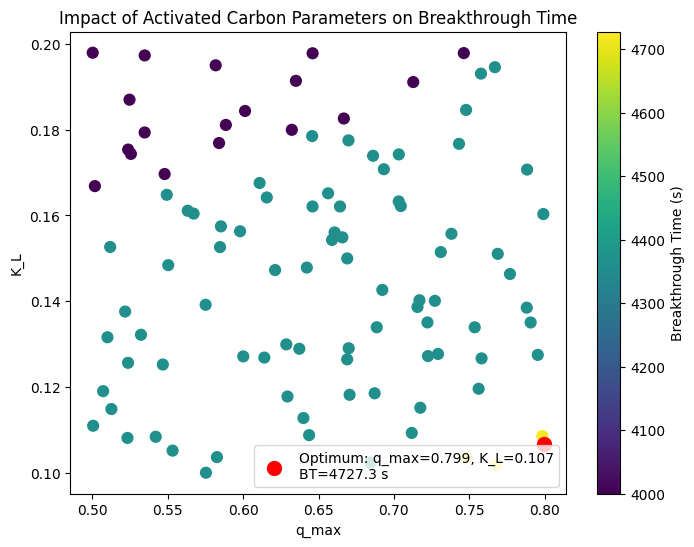

Optimum parameters: q_max = 0.799, K_L = 0.107 with breakthrough time = 4727.3 s


In [ ]:
# %% Additional Cell: Sampling qₘₐₓ and K_L and computing breakthrough times

import numpy as np
import matplotlib.pyplot as plt

# Number of parameter samples
N_samples = 100
# Time grid in the scaled domain
t_scaled = np.linspace(0, T_scaled_max, 100)
# Fixed parameters: outlet location and a representative diffusivity value
x_out = L  # outlet position
D_fixed = (D_min + D_max) / 2  # representative diffusivity

# Define a breakthrough threshold (normalized concentration)
threshold = 0.5

# Function to compute breakthrough time from predicted outlet concentration curve.
def compute_breakthrough_time(t_array, C_normalized, thresh):
    # Find the first time where C_normalized crosses the threshold.
    idx = np.argmax(C_normalized >= thresh)
    if C_normalized[idx] < thresh:
        return t_array[-1]  # if never reaches threshold, return last time
    return t_array[idx]

# Arrays to store the sampled parameters and corresponding breakthrough times
qmax_samples = []
KL_samples = []
breakthrough_times = []

for _ in range(N_samples):
    # Sample qₘₐₓ and K_L uniformly from their ranges
    qmax_val = np.random.uniform(qmax_min, qmax_max)
    KL_val = np.random.uniform(KL_min, KL_max)

    # Create input for the model at the outlet for all times t_scaled
    # Each input vector is [x, t, qmax, K_L, D]
    X_test = np.hstack((
        np.full((len(t_scaled), 1), x_out),
        t_scaled.reshape(-1, 1),
        np.full((len(t_scaled), 1), qmax_val),
        np.full((len(t_scaled), 1), KL_val),
        np.full((len(t_scaled), 1), D_fixed)
    ))

    # Predict concentration using the trained PINN model
    y_pred = model.predict(X_test)
    C_pred = y_pred[:, 0:1].flatten()

    # Normalize the predicted concentration
    C_normalized = C_pred / C0

    # Compute breakthrough time (in scaled time units, then scale to actual time)
    t_br = compute_breakthrough_time(t_scaled, C_normalized, threshold)
    # Convert breakthrough time to seconds (if needed, or hours, etc.)
    t_br_actual = t_br * T_final  # actual breakthrough time in seconds

    qmax_samples.append(qmax_val)
    KL_samples.append(KL_val)
    breakthrough_times.append(t_br_actual)

# Convert lists to arrays for plotting
qmax_samples = np.array(qmax_samples)
KL_samples = np.array(KL_samples)
breakthrough_times = np.array(breakthrough_times)

# Find the optimum (maximum breakthrough time)
opt_idx = np.argmax(breakthrough_times)
opt_qmax = qmax_samples[opt_idx]
opt_KL = KL_samples[opt_idx]
opt_t_br = breakthrough_times[opt_idx]

# Plot the sampling results as a scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(qmax_samples, KL_samples, c=breakthrough_times, cmap='viridis', s=60)
plt.xlabel('q_max')
plt.ylabel('K_L')
cbar = plt.colorbar(scatter)
cbar.set_label('Breakthrough Time (s)')
plt.title('Impact of Activated Carbon Parameters on Breakthrough Time')
plt.scatter(opt_qmax, opt_KL, color='red', s=100, label=f'Optimum: q_max={opt_qmax:.3f}, K_L={opt_KL:.3f}\nBT={opt_t_br:.1f} s')
plt.legend()
plt.show()

# Print optimum values
print(f"Optimum parameters: q_max = {opt_qmax:.3f}, K_L = {opt_KL:.3f} with breakthrough time = {opt_t_br:.1f} s")


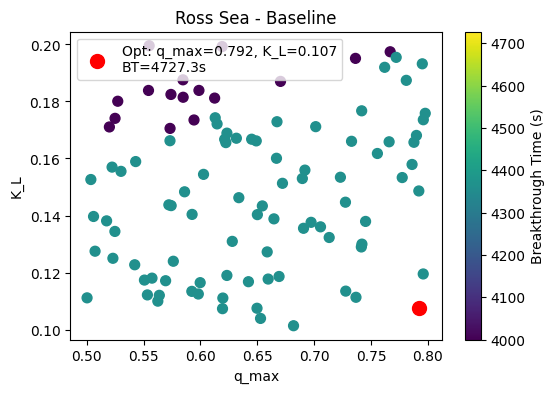

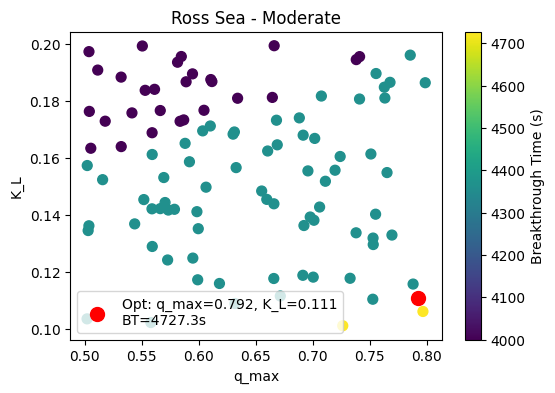

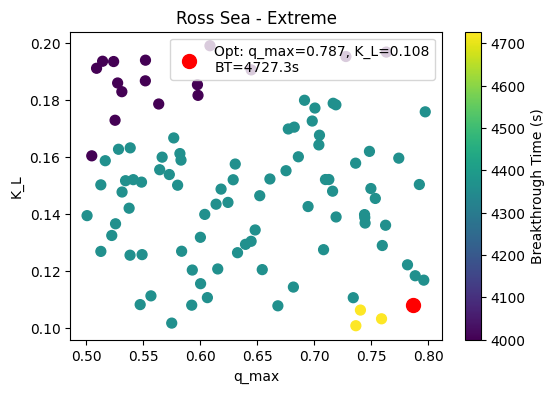

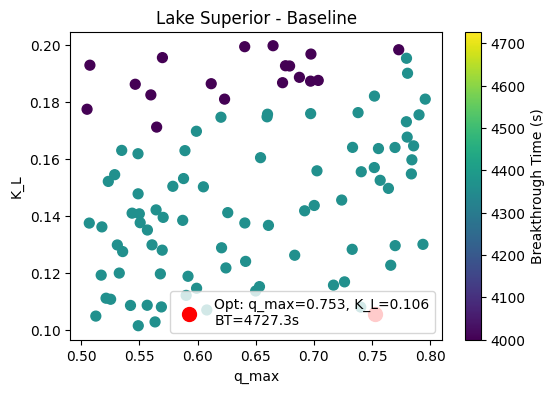

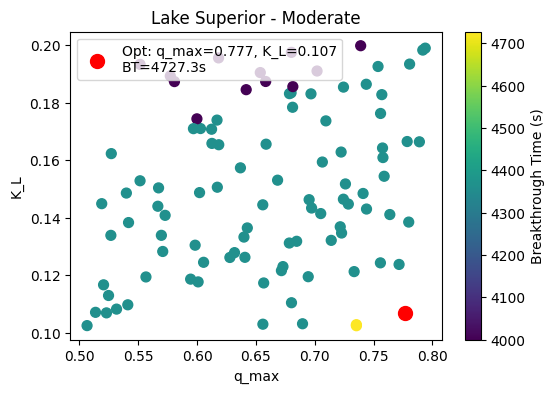

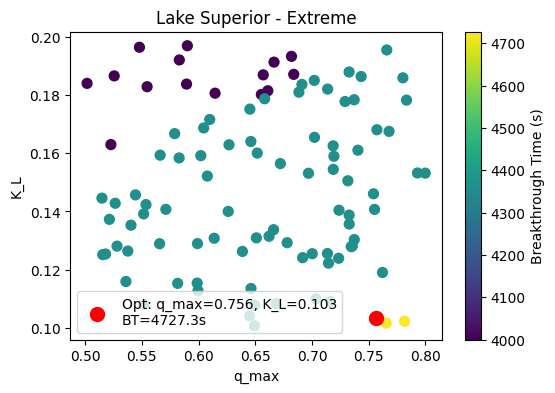

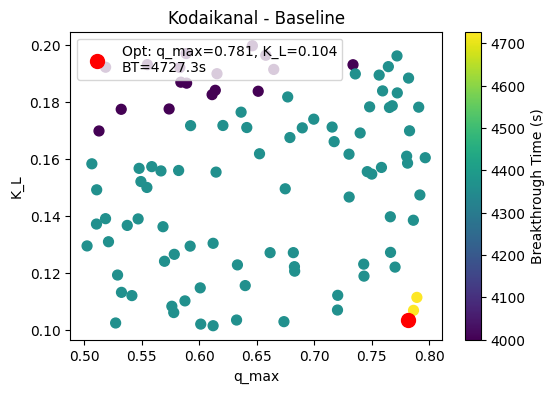

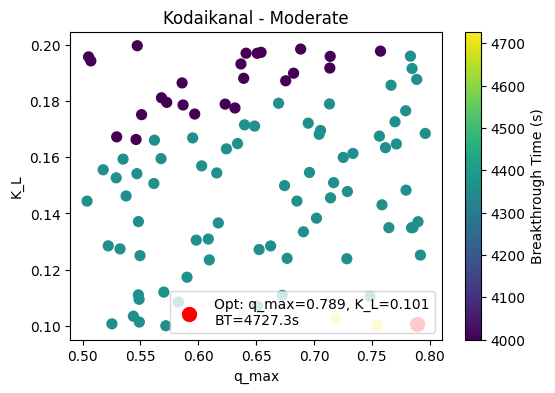

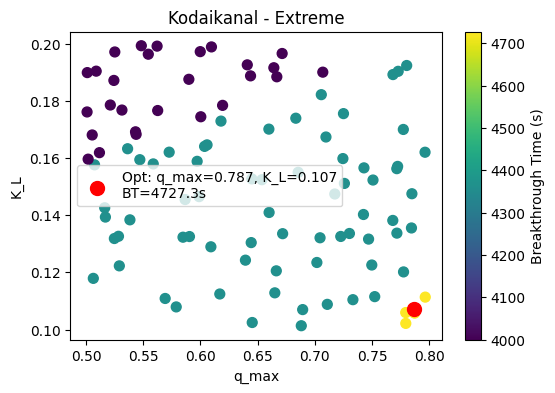

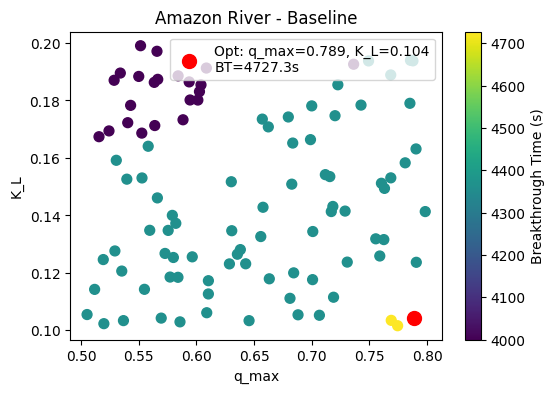

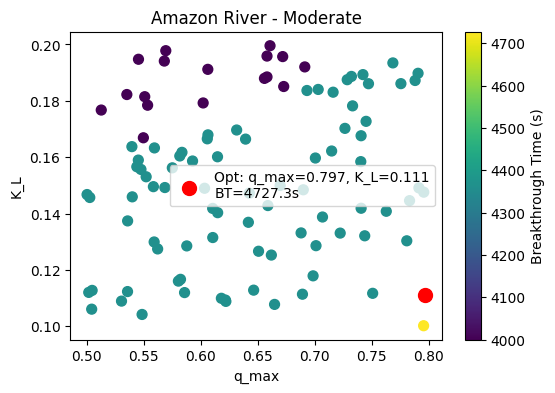

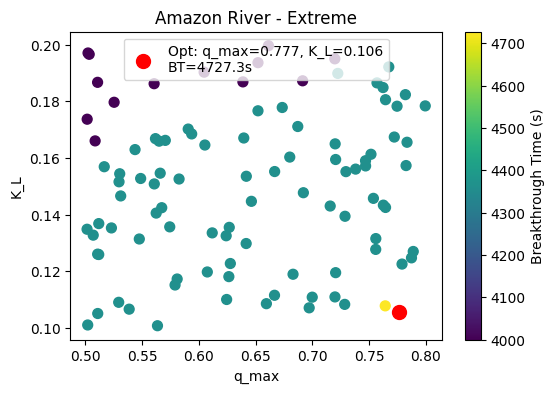

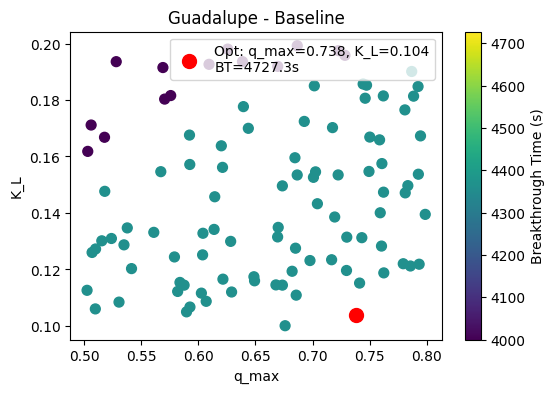

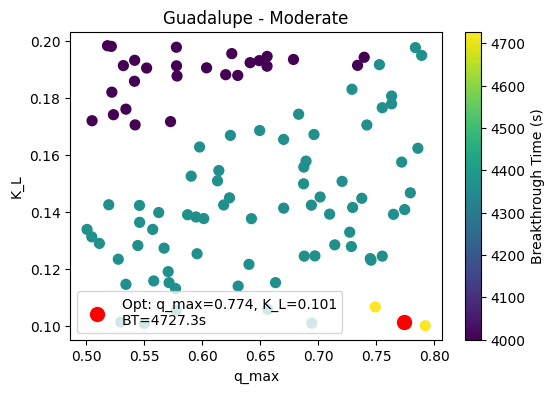

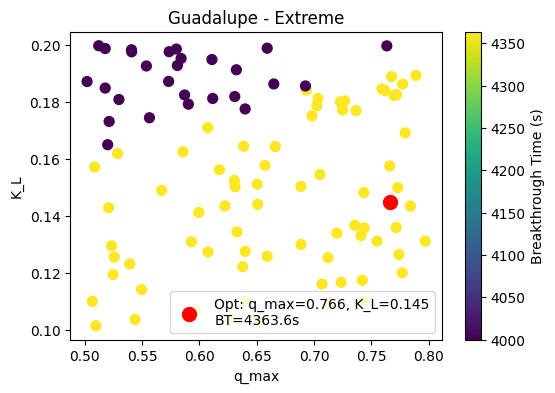

           Region  Scenario  Temp_K   Diffusivity  Opt_q_max   Opt_K_L  \
0        Ross Sea  Baseline  245.25  1.226027e-10   0.792044  0.107496   
1        Ross Sea  Moderate  248.25  1.442704e-10   0.791847  0.110979   
2        Ross Sea   Extreme  251.25  1.683752e-10   0.787029  0.107805   
3   Lake Superior  Baseline  274.82  4.529865e-10   0.752564  0.105554   
4   Lake Superior  Moderate  276.82  4.855653e-10   0.776812  0.106980   
5   Lake Superior   Extreme  278.82  5.195375e-10   0.756383  0.103423   
6      Kodaikanal  Baseline  290.45  7.452445e-10   0.781411  0.103652   
7      Kodaikanal  Moderate  292.45  7.889768e-10   0.789324  0.100595   
8      Kodaikanal   Extreme  294.45  8.341692e-10   0.786510  0.107201   
9    Amazon River  Baseline  300.93  9.906756e-10   0.789080  0.104284   
10   Amazon River  Moderate  303.93  1.068373e-09   0.796940  0.111095   
11   Amazon River   Extreme  306.93  1.149397e-09   0.776528  0.105699   
12      Guadalupe  Baseline  294.75  8

In [ ]:
# %% Revised Cell: Re-including Region Parameters & Sensitivity Analysis

import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
import pandas as pd

# --- Temperature Diffusion Model Functions ---
k_B = 1.380649e-23  # Boltzmann constant (J/K)
r = (0.102 + 0.168) * 1e-9  # Effective radius (m)
P_C = 22.064e6  # Critical pressure (Pa)
omega = 0.344   # Acentric factor

def dynamic_viscosity(T_K):
    """Compute viscosity at saturated liquid conditions."""
    return 2.414e-5 * 10**(247.8 / (T_K - 140))

def reduced_pressure(P, T_K):
    """Compute reduced pressure using Antoine equation."""
    P_VP = 10**(5.053988 - (1647.6 / (T_K + 226))) * 101325
    return (P - P_VP) / P_C

def lucas_coefficients(T_R):
    """Compute Lucas method coefficients."""
    A = 0.9991 - (4.674e-4 / (1.0523 * T_R - 0.3877 - 1.0513))
    D_val = 0.3257 / (1.0039 - T_R**2.573)**0.2096 - 0.2086
    C_val = (-0.07921 + 2.1616 * T_R - 13.4040 * T_R**2 +
             44.1706 * T_R**3 - 84.8291 * T_R**4 +
             96.1209 * T_R**5 - 59.8127 * T_R**6 + 15.6719 * T_R**7)
    return A, D_val, C_val

def adjusted_viscosity(mu_SL, delta_P_R, A, D_val, C_val):
    """Adjust viscosity using the Lucas method."""
    return mu_SL * (1 + D_val * delta_P_R * A / 2.118) / (1 + C_val * omega * delta_P_R)

def diffusion_coefficient(T_K, r, viscosity):
    """Compute diffusion coefficient using the Einstein-Stokes equation."""
    return k_B * T_K / (6 * np.pi * viscosity * r)

# --- Region Parameters ---
locations = ["Ross Sea", "Lake Superior", "Kodaikanal", "Amazon River", "Guadalupe"]
temperatures_C = [-27.90, 1.67, 17.30, 27.78, 21.60]
pressures_Pa = [98780.0, 101325.0, 101660.0, 101325.0, 102608.0]

region_info = {
    "Ross Sea": {"index": 0, "offsets": {"moderate": 3, "extreme": 6}},
    "Lake Superior": {"index": 1, "offsets": {"moderate": 2, "extreme": 4}},
    "Kodaikanal": {"index": 2, "offsets": {"moderate": 2, "extreme": 4}},
    "Amazon River": {"index": 3, "offsets": {"moderate": 3, "extreme": 6}},
    "Guadalupe": {"index": 4, "offsets": {"moderate": 2, "extreme": 4}},
}

# --- Operating Parameters ---
v = 0.01          # Flow rate (m/s)
L = 0.5           # Domain length (m)
T_final = 36000   # Final simulation time (s)
T_scaled_max = 1.0
C0 = 100          # Inlet concentration
k_f = 2e-4        # Forward rate constant

# --- Activated Carbon Parameter Ranges for Sensitivity Analysis ---
qmax_min, qmax_max = 0.5, 0.8    # Range for q_max
KL_min, KL_max     = 0.1, 0.2     # Range for K_L

# Assume the PINN model (from snippet 2) is already trained and available as "model"

# %% Sensitivity Analysis: Optimize q_max and K_L per Region & Climate Scenario
N_samples = 100   # Number of samples per region-scenario
threshold = 0.5   # Breakthrough threshold (normalized concentration)
results_list = []

for region in region_info:
    idx = region_info[region]["index"]
    base_temp_C = temperatures_C[idx]
    base_temp_K = base_temp_C + 273.15
    pressure = pressures_Pa[idx]

    for scenario in ["Baseline", "Moderate", "Extreme"]:
        # Determine temperature offset
        offset = 0 if scenario == "Baseline" else region_info[region]["offsets"][scenario.lower()]
        temp_K = base_temp_K + offset

        # Compute region-specific diffusivity (using the Antoine equations etc.)
        T_R = temp_K / 647.3
        mu_SL = dynamic_viscosity(temp_K)
        A_val, D_val, C_val = lucas_coefficients(T_R)
        delta_P_R = reduced_pressure(pressure, temp_K)
        mu_adjusted = adjusted_viscosity(mu_SL, delta_P_R, A_val, D_val, C_val)
        diffusivity = diffusion_coefficient(temp_K, r, mu_adjusted)

        # Prepare storage for sample results
        qmax_samples = []
        KL_samples = []
        breakthrough_times = []  # in seconds

        # Time grid (scaled)
        t_scaled = np.linspace(0, T_scaled_max, 100)
        x_out = L  # outlet position

        for _ in range(N_samples):
            # Randomly sample q_max and K_L from the defined ranges
            qmax_val = np.random.uniform(qmax_min, qmax_max)
            KL_val = np.random.uniform(KL_min, KL_max)

            # Build input for the PINN model: [x, t, q_max, K_L, D]
            # Use the region-specific diffusivity computed above.
            X_test = np.hstack((
                np.full((len(t_scaled), 1), x_out),
                t_scaled.reshape(-1, 1),
                np.full((len(t_scaled), 1), qmax_val),
                np.full((len(t_scaled), 1), KL_val),
                np.full((len(t_scaled), 1), diffusivity)
            ))

            # Predict concentration at the outlet over time
            y_pred = model.predict(X_test)
            C_pred = y_pred[:, 0].flatten()
            C_normalized = C_pred / C0

            # Determine breakthrough time: first time when normalized concentration >= threshold
            indices = np.where(C_normalized >= threshold)[0]
            if len(indices) == 0:
                t_br = T_scaled_max * T_final  # if threshold not reached, use max time
            else:
                t_br = t_scaled[indices[0]] * T_final  # scale back to actual time (seconds)

            qmax_samples.append(qmax_val)
            KL_samples.append(KL_val)
            breakthrough_times.append(t_br)

        # Identify optimum sample (maximum breakthrough time)
        opt_idx = np.argmax(breakthrough_times)
        opt_qmax = qmax_samples[opt_idx]
        opt_KL = KL_samples[opt_idx]
        opt_bt = breakthrough_times[opt_idx]

        # Store results for summary table
        results_list.append({
            "Region": region,
            "Scenario": scenario,
            "Temp_K": temp_K,
            "Diffusivity": diffusivity,
            "Opt_q_max": opt_qmax,
            "Opt_K_L": opt_KL,
            "Breakthrough_Time (s)": opt_bt
        })

        # Plot scatter for the current region-scenario
        plt.figure(figsize=(6,4))
        sc = plt.scatter(qmax_samples, KL_samples, c=breakthrough_times, cmap='viridis', s=50)
        plt.xlabel("q_max")
        plt.ylabel("K_L")
        plt.title(f"{region} - {scenario}")
        cbar = plt.colorbar(sc)
        cbar.set_label("Breakthrough Time (s)")
        plt.scatter(opt_qmax, opt_KL, color='red', s=100,
                    label=f"Opt: q_max={opt_qmax:.3f}, K_L={opt_KL:.3f}\nBT={opt_bt:.1f}s")
        plt.legend()
        plt.show()

# Create a summary table (DataFrame) of the optimized parameters per region and scenario
df_results = pd.DataFrame(results_list)
print(df_results)


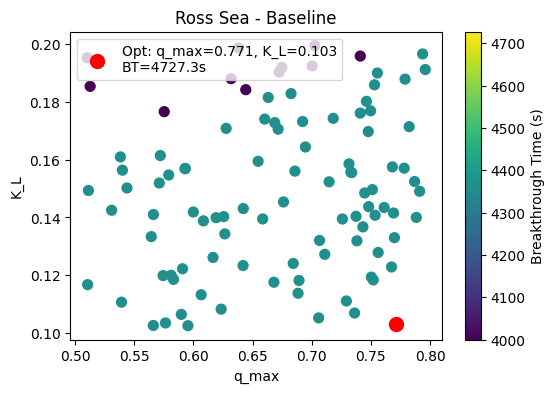

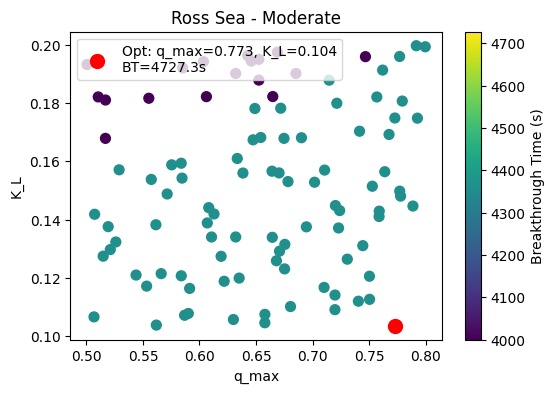

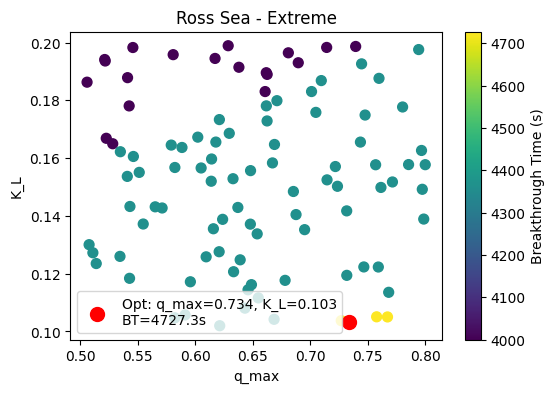

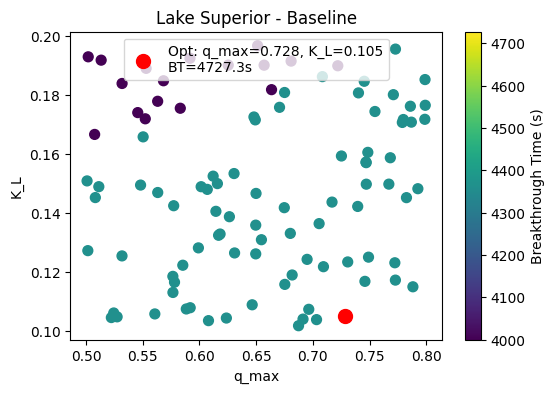

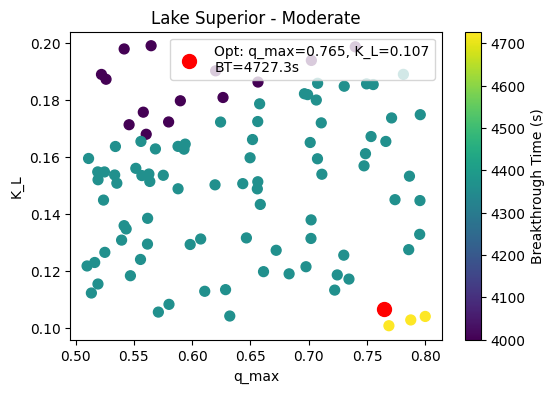

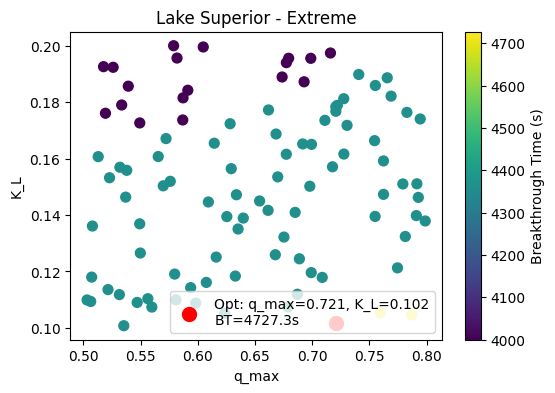

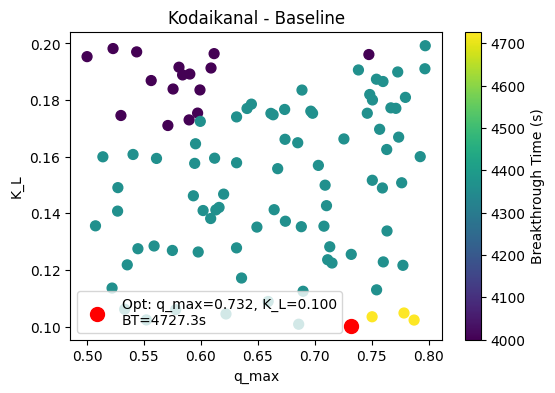

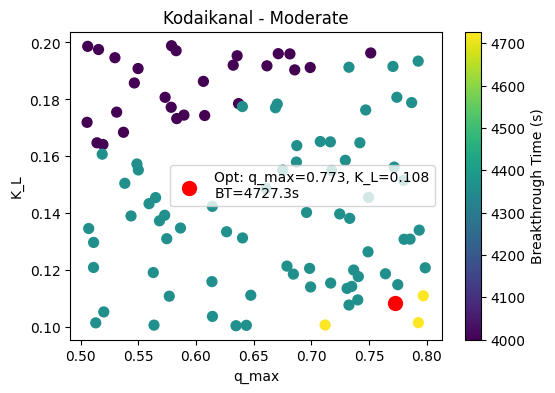

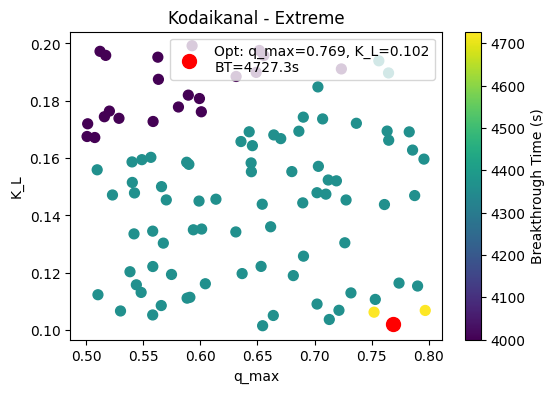

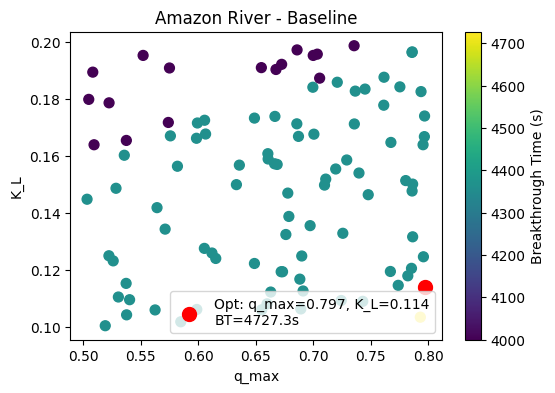

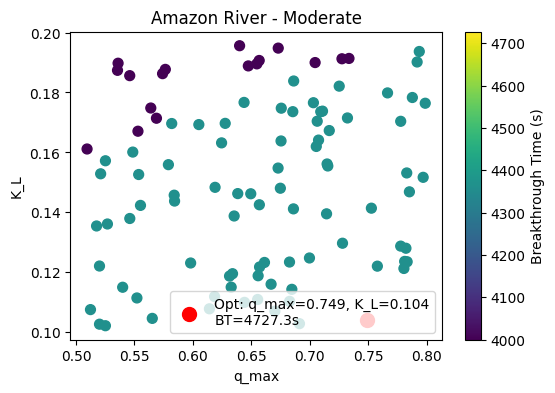

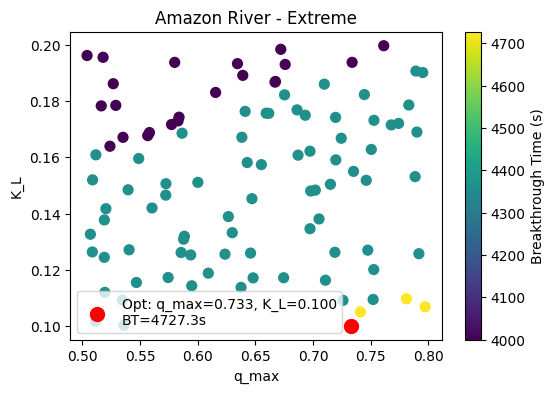

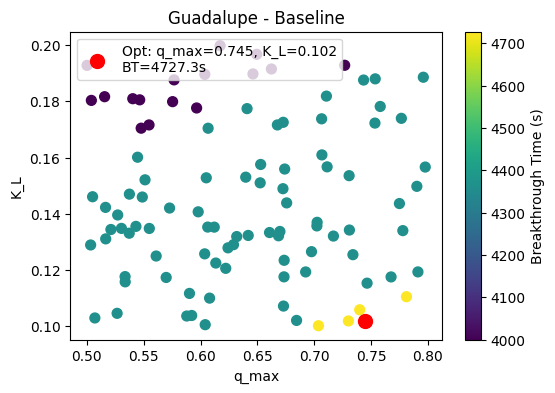

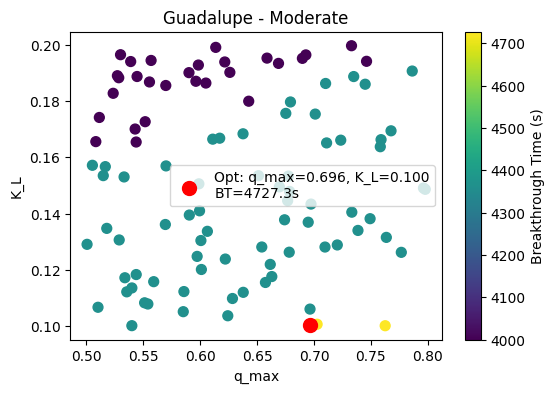

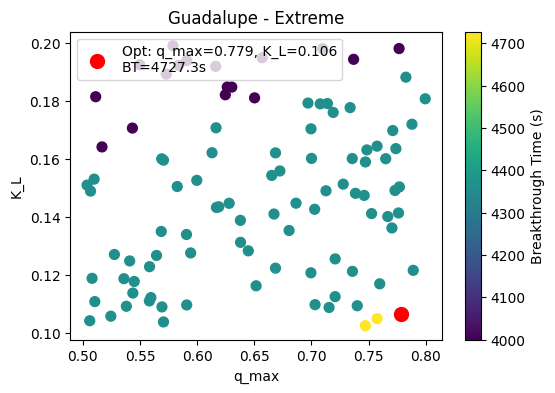

           Region  Scenario  Temp_K   Diffusivity  Opt_q_max   Opt_K_L  \
0        Ross Sea  Baseline  245.25  1.226027e-10   0.770924  0.103205   
1        Ross Sea  Moderate  248.25  1.442704e-10   0.773201  0.103644   
2        Ross Sea   Extreme  251.25  1.683752e-10   0.733755  0.103308   
3   Lake Superior  Baseline  274.82  4.529865e-10   0.728116  0.104921   
4   Lake Superior  Moderate  276.82  4.855653e-10   0.764741  0.106730   
5   Lake Superior   Extreme  278.82  5.195375e-10   0.720784  0.101817   
6      Kodaikanal  Baseline  290.45  7.452445e-10   0.732135  0.100313   
7      Kodaikanal  Moderate  292.45  7.889768e-10   0.772842  0.108389   
8      Kodaikanal   Extreme  294.45  8.341692e-10   0.768704  0.102121   
9    Amazon River  Baseline  300.93  9.906756e-10   0.797480  0.114056   
10   Amazon River  Moderate  303.93  1.068373e-09   0.748865  0.104128   
11   Amazon River   Extreme  306.93  1.149397e-09   0.733060  0.100197   
12      Guadalupe  Baseline  294.75  8

In [ ]:
# %% Revised Cell: Re-including Region Parameters & Sensitivity Analysis

import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
import pandas as pd

# --- Temperature Diffusion Model Functions ---
k_B = 1.380649e-23  # Boltzmann constant (J/K)
r = (0.102 + 0.168) * 1e-9  # Effective radius (m)
P_C = 22.064e6  # Critical pressure (Pa)
omega = 0.344   # Acentric factor

def dynamic_viscosity(T_K):
    """Compute viscosity at saturated liquid conditions."""
    return 2.414e-5 * 10**(247.8 / (T_K - 140))

def reduced_pressure(P, T_K):
    """Compute reduced pressure using Antoine equation."""
    P_VP = 10**(5.053988 - (1647.6 / (T_K + 226))) * 101325
    return (P - P_VP) / P_C

def lucas_coefficients(T_R):
    """Compute Lucas method coefficients."""
    A = 0.9991 - (4.674e-4 / (1.0523 * T_R - 0.3877 - 1.0513))
    D_val = 0.3257 / (1.0039 - T_R**2.573)**0.2096 - 0.2086
    C_val = (-0.07921 + 2.1616 * T_R - 13.4040 * T_R**2 +
             44.1706 * T_R**3 - 84.8291 * T_R**4 +
             96.1209 * T_R**5 - 59.8127 * T_R**6 + 15.6719 * T_R**7)
    return A, D_val, C_val

def adjusted_viscosity(mu_SL, delta_P_R, A, D_val, C_val):
    """Adjust viscosity using the Lucas method."""
    return mu_SL * (1 + D_val * delta_P_R * A / 2.118) / (1 + C_val * omega * delta_P_R)

def diffusion_coefficient(T_K, r, viscosity):
    """Compute diffusion coefficient using the Einstein-Stokes equation."""
    return k_B * T_K / (6 * np.pi * viscosity * r)

# --- Region Parameters ---
locations = ["Ross Sea", "Lake Superior", "Kodaikanal", "Amazon River", "Guadalupe"]
temperatures_C = [-27.90, 1.67, 17.30, 27.78, 21.60]
pressures_Pa = [98780.0, 101325.0, 101660.0, 101325.0, 102608.0]

region_info = {
    "Ross Sea": {"index": 0, "offsets": {"moderate": 3, "extreme": 6}},
    "Lake Superior": {"index": 1, "offsets": {"moderate": 2, "extreme": 4}},
    "Kodaikanal": {"index": 2, "offsets": {"moderate": 2, "extreme": 4}},
    "Amazon River": {"index": 3, "offsets": {"moderate": 3, "extreme": 6}},
    "Guadalupe": {"index": 4, "offsets": {"moderate": 2, "extreme": 4}},
}

# --- Operating Parameters ---
v = 0.01          # Flow rate (m/s)
L = 0.5           # Domain length (m)
T_final = 36000   # Final simulation time (s)
T_scaled_max = 1.0
C0 = 100          # Inlet concentration
k_f = 2e-4        # Forward rate constant

# --- Activated Carbon Parameter Ranges for Sensitivity Analysis ---
qmax_min, qmax_max = 0.5, 0.8    # Range for q_max
KL_min, KL_max     = 0.1, 0.2     # Range for K_L

# Assume the PINN model (from snippet 2) is already trained and available as "model"

# %% Sensitivity Analysis: Optimize q_max and K_L per Region & Climate Scenario
N_samples = 100   # Number of samples per region-scenario
threshold = 0.5   # Breakthrough threshold (normalized concentration)
results_list = []

for region in region_info:
    idx = region_info[region]["index"]
    base_temp_C = temperatures_C[idx]
    base_temp_K = base_temp_C + 273.15
    pressure = pressures_Pa[idx]

    for scenario in ["Baseline", "Moderate", "Extreme"]:
        # Determine temperature offset
        offset = 0 if scenario == "Baseline" else region_info[region]["offsets"][scenario.lower()]
        temp_K = base_temp_K + offset

        # Compute region-specific diffusivity (using the Antoine equations etc.)
        T_R = temp_K / 647.3
        mu_SL = dynamic_viscosity(temp_K)
        A_val, D_val, C_val = lucas_coefficients(T_R)
        delta_P_R = reduced_pressure(pressure, temp_K)
        mu_adjusted = adjusted_viscosity(mu_SL, delta_P_R, A_val, D_val, C_val)
        diffusivity = diffusion_coefficient(temp_K, r, mu_adjusted)

        # Prepare storage for sample results
        qmax_samples = []
        KL_samples = []
        breakthrough_times = []  # in seconds

        # Time grid (scaled)
        t_scaled = np.linspace(0, T_scaled_max, 100)
        x_out = L  # outlet position

        for _ in range(N_samples):
            # Randomly sample q_max and K_L from the defined ranges
            qmax_val = np.random.uniform(qmax_min, qmax_max)
            KL_val = np.random.uniform(KL_min, KL_max)

            # Build input for the PINN model: [x, t, q_max, K_L, D]
            # Use the region-specific diffusivity computed above.
            X_test = np.hstack((
                np.full((len(t_scaled), 1), x_out),
                t_scaled.reshape(-1, 1),
                np.full((len(t_scaled), 1), qmax_val),
                np.full((len(t_scaled), 1), KL_val),
                np.full((len(t_scaled), 1), diffusivity)
            ))

            # Predict concentration at the outlet over time
            y_pred = model.predict(X_test)
            C_pred = y_pred[:, 0].flatten()
            C_normalized = C_pred / C0

            # Determine breakthrough time: first time when normalized concentration >= threshold
            indices = np.where(C_normalized >= threshold)[0]
            if len(indices) == 0:
                t_br = T_scaled_max * T_final  # if threshold not reached, use max time
            else:
                t_br = t_scaled[indices[0]] * T_final  # scale back to actual time (seconds)

            qmax_samples.append(qmax_val)
            KL_samples.append(KL_val)
            breakthrough_times.append(t_br)

        # Identify optimum sample (maximum breakthrough time)
        opt_idx = np.argmax(breakthrough_times)
        opt_qmax = qmax_samples[opt_idx]
        opt_KL = KL_samples[opt_idx]
        opt_bt = breakthrough_times[opt_idx]

        # Store results for summary table
        results_list.append({
            "Region": region,
            "Scenario": scenario,
            "Temp_K": temp_K,
            "Diffusivity": diffusivity,
            "Opt_q_max": opt_qmax,
            "Opt_K_L": opt_KL,
            "Breakthrough_Time (s)": opt_bt
        })

        # Plot scatter for the current region-scenario
        plt.figure(figsize=(6,4))
        sc = plt.scatter(qmax_samples, KL_samples, c=breakthrough_times, cmap='viridis', s=50)
        plt.xlabel("q_max")
        plt.ylabel("K_L")
        plt.title(f"{region} - {scenario}")
        cbar = plt.colorbar(sc)
        cbar.set_label("Breakthrough Time (s)")
        plt.scatter(opt_qmax, opt_KL, color='red', s=100,
                    label=f"Opt: q_max={opt_qmax:.3f}, K_L={opt_KL:.3f}\nBT={opt_bt:.1f}s")
        plt.legend()
        plt.show()

# Create a summary table (DataFrame) of the optimized parameters per region and scenario
df_results = pd.DataFrame(results_list)
print(df_results)


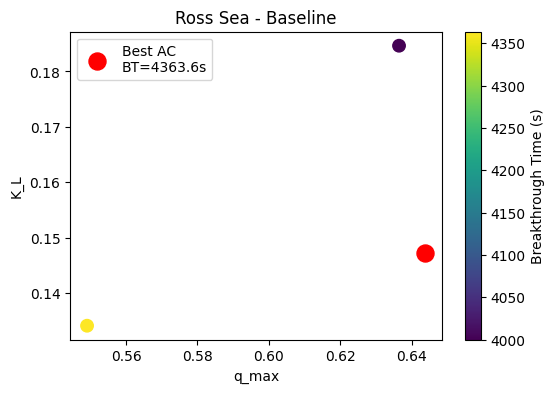

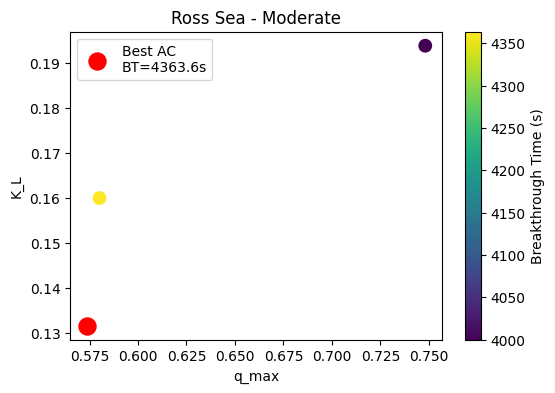

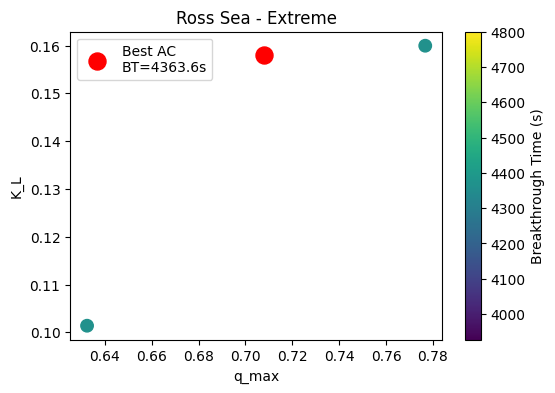

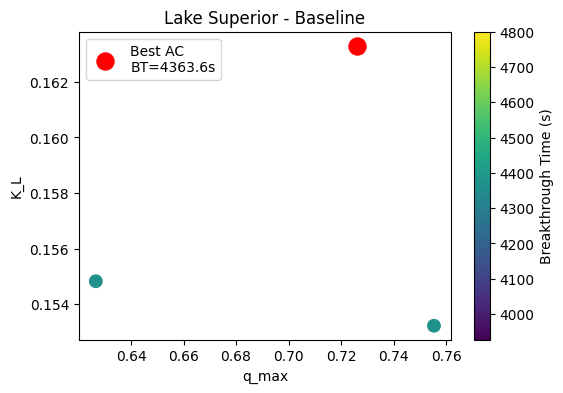

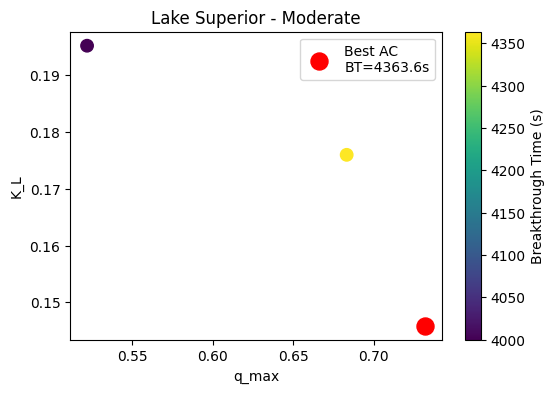

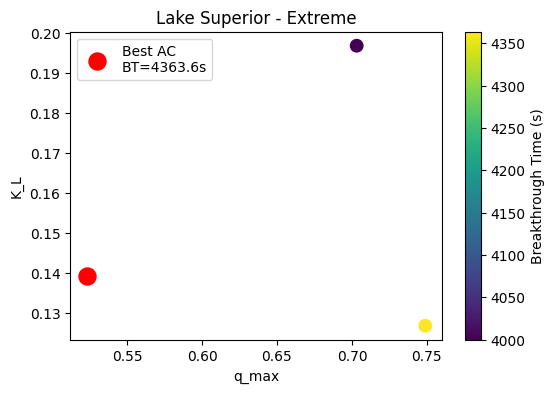

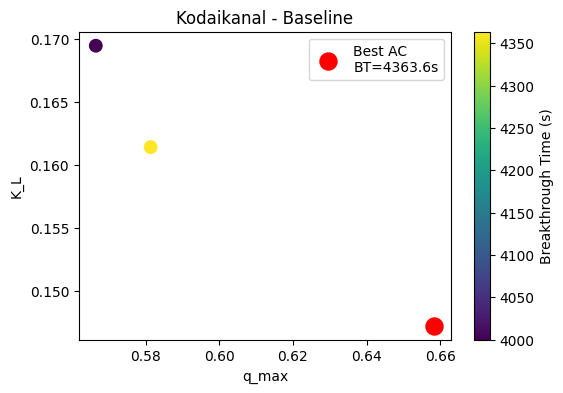

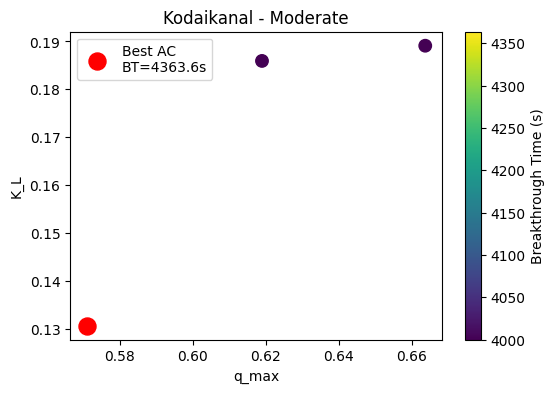

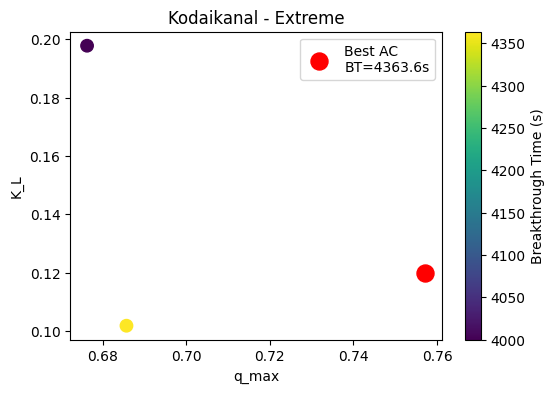

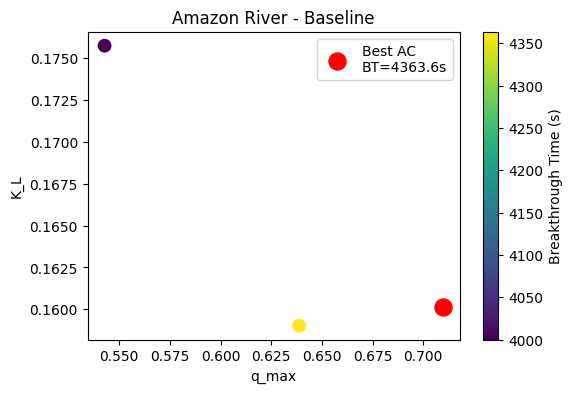

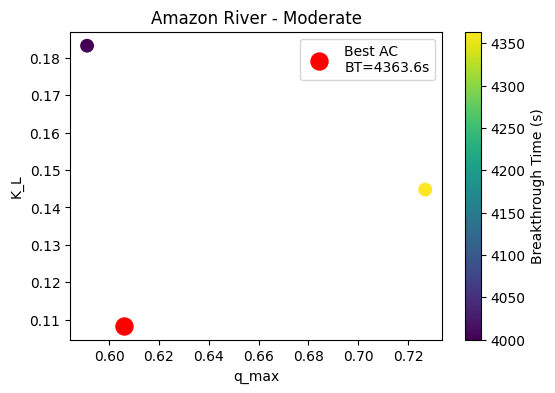

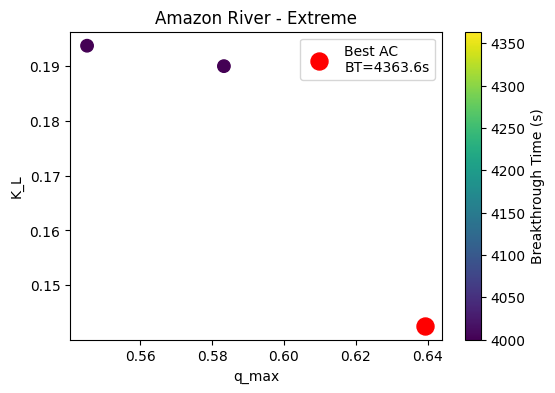

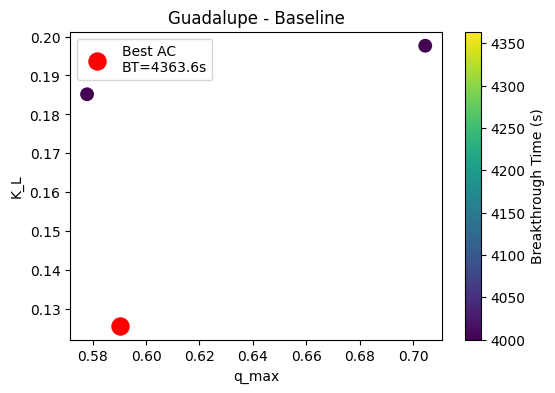

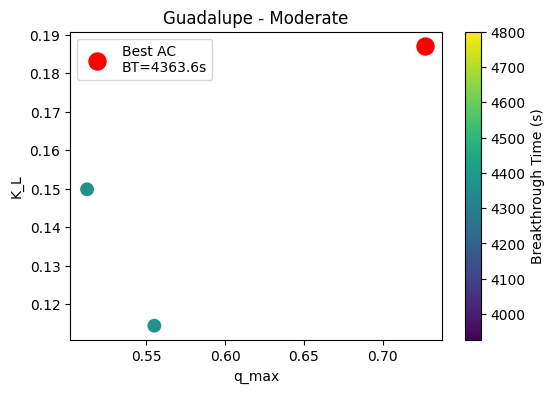

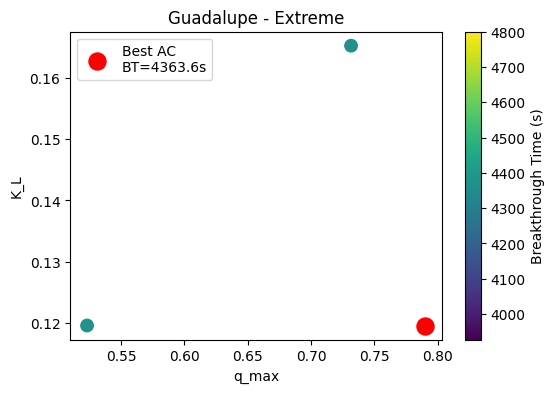

Optimized Activated Carbon per Region and Scenario:
       q_max       K_L  Breakthrough_Time (s)         Region  Scenario  \
0   0.643726  0.147289            4363.636364       Ross Sea  Baseline   
1   0.573712  0.131573            4363.636364       Ross Sea  Moderate   
2   0.708068  0.158066            4363.636364       Ross Sea   Extreme   
3   0.726054  0.163303            4363.636364  Lake Superior  Baseline   
4   0.731858  0.145883            4363.636364  Lake Superior  Moderate   
5   0.523293  0.139365            4363.636364  Lake Superior   Extreme   
6   0.658319  0.147227            4363.636364     Kodaikanal  Baseline   
7   0.570999  0.130597            4363.636364     Kodaikanal  Moderate   
8   0.757175  0.119816            4363.636364     Kodaikanal   Extreme   
9   0.709610  0.160135            4363.636364   Amazon River  Baseline   
10  0.605981  0.108398            4363.636364   Amazon River  Moderate   
11  0.639314  0.142604            4363.636364   Amazon River

In [ ]:
# %% Cell: Evaluate Sample Activated Carbons per Region and Scenario

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Literature-based ranges for activated carbon parameters
qmax_min, qmax_max = 0.5, 0.8    # Typical range for q_max
KL_min, KL_max     = 0.1, 0.2     # Typical range for K_L

N_samples_AC = 3   # Number of sample activated carbons per region-scenario
threshold = 0.5    # Normalized concentration threshold for breakthrough

results_list = []

# Loop over each region and climate scenario
for region in region_info:
    idx = region_info[region]["index"]
    base_temp_C = temperatures_C[idx]
    base_temp_K = base_temp_C + 273.15
    pressure = pressures_Pa[idx]

    for scenario in ["Baseline", "Moderate", "Extreme"]:
        # Temperature offset based on scenario
        offset = 0 if scenario == "Baseline" else region_info[region]["offsets"][scenario.lower()]
        temp_K = base_temp_K + offset

        # Compute diffusivity using the physical model
        T_R = temp_K / 647.3
        mu_SL = dynamic_viscosity(temp_K)
        A_val, D_val, C_val = lucas_coefficients(T_R)
        delta_P_R = reduced_pressure(pressure, temp_K)
        mu_adjusted = adjusted_viscosity(mu_SL, delta_P_R, A_val, D_val, C_val)
        diffusivity = diffusion_coefficient(temp_K, r, mu_adjusted)

        ac_results = []  # To store each AC sample's performance

        # Time grid for prediction (scaled)
        t_scaled = np.linspace(0, T_scaled_max, 100)
        x_out = L  # Outlet position

        for i in range(N_samples_AC):
            # Generate a random sample for activated carbon parameters
            qmax_val = np.random.uniform(qmax_min, qmax_max)
            KL_val = np.random.uniform(KL_min, KL_max)

            # Build the input for the PINN: [x, t, q_max, K_L, D]
            X_test = np.hstack((
                np.full((len(t_scaled), 1), x_out),
                t_scaled.reshape(-1, 1),
                np.full((len(t_scaled), 1), qmax_val),
                np.full((len(t_scaled), 1), KL_val),
                np.full((len(t_scaled), 1), diffusivity)
            ))

            # Predict concentration at the outlet using the trained model
            y_pred = model.predict(X_test)
            C_pred = y_pred[:, 0].flatten()
            C_normalized = C_pred / C0

            # Determine breakthrough time: first time when concentration exceeds threshold
            indices = np.where(C_normalized >= threshold)[0]
            if len(indices) == 0:
                t_br = T_scaled_max * T_final  # Use maximum simulation time if threshold not reached
            else:
                t_br = t_scaled[indices[0]] * T_final  # Scale back to actual time (seconds)

            ac_results.append({
                "q_max": qmax_val,
                "K_L": KL_val,
                "Breakthrough_Time (s)": t_br
            })

        # Identify the activated carbon sample with the maximum breakthrough time
        best_ac = max(ac_results, key=lambda ac: ac["Breakthrough_Time (s)"])
        best_ac["Region"] = region
        best_ac["Scenario"] = scenario
        best_ac["Temp_K"] = temp_K
        best_ac["Diffusivity"] = diffusivity

        results_list.append(best_ac)

        # Plot the sample breakthrough times for visualization
        plt.figure(figsize=(6,4))
        q_vals = [ac["q_max"] for ac in ac_results]
        KL_vals = [ac["K_L"] for ac in ac_results]
        BT_vals = [ac["Breakthrough_Time (s)"] for ac in ac_results]
        sc = plt.scatter(q_vals, KL_vals, c=BT_vals, cmap='viridis', s=80)
        plt.xlabel("q_max")
        plt.ylabel("K_L")
        plt.title(f"{region} - {scenario}")
        cbar = plt.colorbar(sc)
        cbar.set_label("Breakthrough Time (s)")
        plt.scatter(best_ac["q_max"], best_ac["K_L"], color='red', s=150, label=f"Best AC\nBT={best_ac['Breakthrough_Time (s)']:.1f}s")
        plt.legend()
        plt.show()

# Create a summary DataFrame showing the optimal AC per region and scenario
df_best_AC = pd.DataFrame(results_list)
print("Optimized Activated Carbon per Region and Scenario:")
print(df_best_AC)